# Coursework 1

This notebook is intended to be used as a starting point for your experiments. The instructions can be found in the MLP2025_26_CW1_Spec.pdf (see Learn,  Assignment Submission, Coursework 1). The methods provided here are just helper functions. If you want more complex graphs such as side by side comparisons of different experiments you should learn more about matplotlib and implement them. Before each experiment remember to re-initialize neural network weights and reset the data providers so you get a properly initialized experiment. For each experiment try to keep most hyperparameters the same except the one under investigation so you can understand what the effects of each are.

## Training Boilerplate

Use the below code as a boilerplate to start your experiments. You can add more cells or change the code as you see fit.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import logging
import sys, os
os.chdir("/Users/ashu/Downloads/MLP/mlp_cw2")  # Change to the mlpractical directory
print(os.getcwd())
from mlp.data_providers import MNISTDataProvider, EMNISTDataProvider
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, CustomActivationLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule
from mlp.optimisers import Optimiser

/Users/ashu/Downloads/MLP/mlp_cw2


In [10]:
%matplotlib inline
plt.style.use('ggplot')

def train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True):
    
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors, notebook=notebook)

    # Run the optimiser for num_epochs epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    ax_1.set_ylabel('Error')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    ax_2.set_xlabel('Accuracy')

    grad_plot, grad_ax = optimiser.plot_grad_flow()

    return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax

In [6]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.

# Seed a random number generator
seed = 111020
rng = np.random.RandomState(seed)
batch_size = 100
# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]
print(os.getcwd())
os.environ['MLP_DATA_DIR'] = os.path.join(os.getcwd(), 'mlpractical/data')


# Create data provider objects for the MNIST data set
train_data = EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
valid_data = EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)

/Users/ashu/Downloads/MLP/mlp_cw2
KeysView(NpzFile '/Users/ashu/Downloads/MLP/mlp_cw2/mlpractical/data/emnist-train.npz' with keys: inputs, targets)
KeysView(NpzFile '/Users/ashu/Downloads/MLP/mlp_cw2/mlpractical/data/emnist-valid.npz' with keys: inputs, targets)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 237.77it/s]
Epoch 1: 4.2s to complete
    error(train)=7.72e-01, acc(train)=7.60e-01, error(valid)=7.87e-01, acc(valid)=7.58e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 255.63it/s]
Epoch 2: 3.9s to complete
    error(train)=5.85e-01, acc(train)=8.13e-01, error(valid)=6.21e-01, acc(valid)=8.03e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 261.95it/s]
Epoch 3: 3.8s to complete
    error(train)=5.02e-01, acc(train)=8.36e-01, error(valid)=5.56e-01, acc(valid)=8.19e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 223.61it/s]
Epoch 4: 4.5s to complete
    error(train)=4.68e-01, acc(train)=8.43e-01, error(valid)=5.45e-01, acc(valid)=8.22e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 247.29it/s]
Epoch 5: 4.1s to complete
    error(train)=4.46e-01, acc(train)=8.42e-01, error(valid)=5.39e-01, acc(valid)=8.17e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 218.36it/s]
Epoch 6: 4.6s to complete
    error(train)=

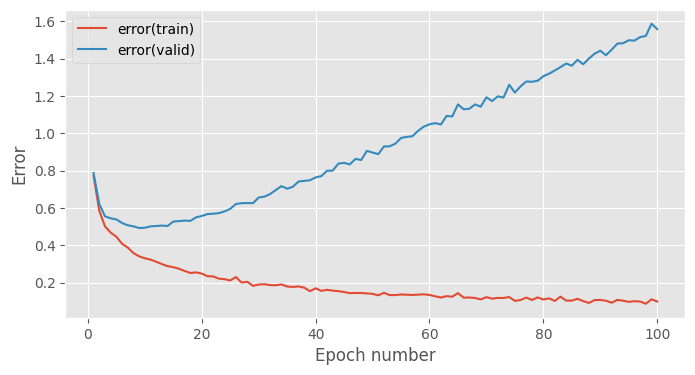

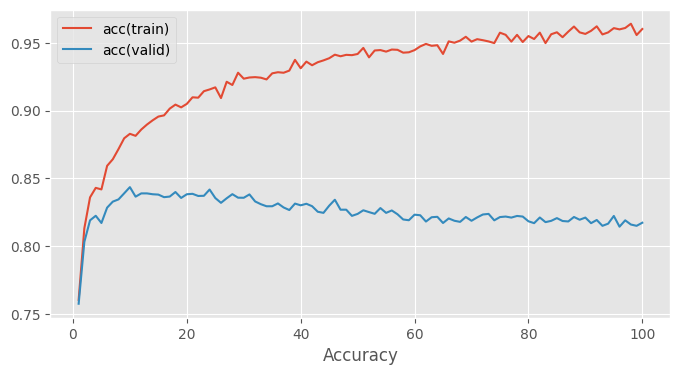

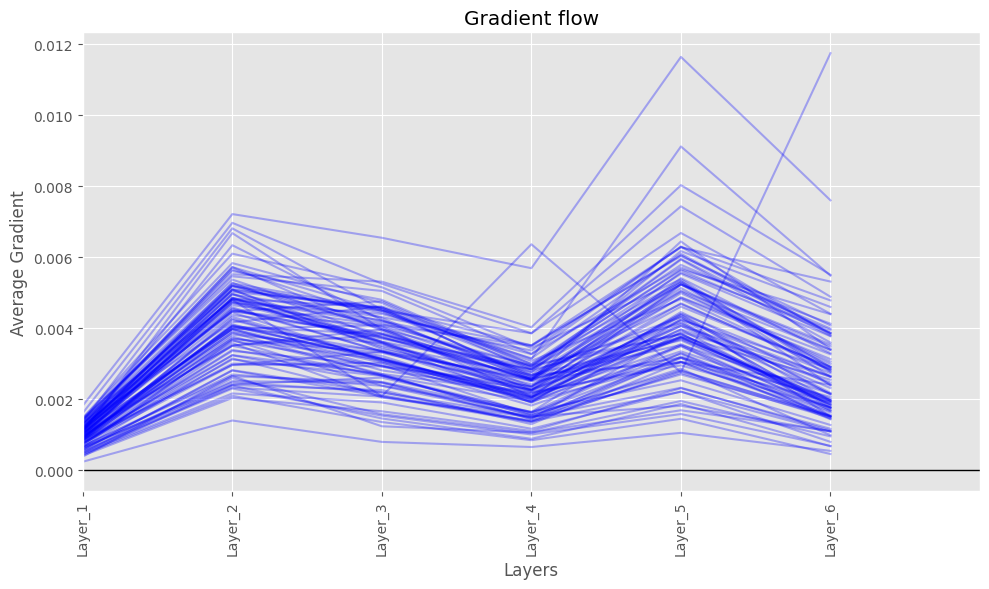

In [13]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.

%pip install tqdm

# Setup hyperparameters
learning_rate = 0.001
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Create model with TWO hidden layers
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), # first hidden layer
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), # second hidden layer
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init) # output layer
])

error = CrossEntropySoftmaxError()
# Use a Adam learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate)

# Remember to use notebook=False when you write a script to be run in a terminal
stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=False)

In [14]:
# Saving the figures
fig_1.savefig('baseline_error.pdf')
fig_2.savefig('baseline_accuracy.pdf')

# Printing the results
print("\nTraining completed")
print("Time taken:", run_time, "seconds")
print("Final training error:", stats[-1, keys['error(train)']])
print("Final validation error:", stats[-1, keys['error(valid)']])
print("Final training accuracy:", stats[-1, keys['acc(train)']])
print("Final validation accuracy:", stats[-1, keys['acc(valid)']])


Training completed
Time taken: 465.6633241176605 seconds
Final training error: 0.0994889479084279
Final validation error: 1.5581905322519698
Final training accuracy: 0.9601900000000132
Final validation accuracy: 0.8172784810126582


Training with 32 hidden units


Ep Prog: 100%|██████████| 1000/1000 [00:01<00:00, 828.84it/s]
Epoch 1: 1.2s to complete
    error(train)=1.26e+00, acc(train)=6.52e-01, error(valid)=1.27e+00, acc(valid)=6.48e-01
Ep Prog: 100%|██████████| 1000/1000 [00:01<00:00, 965.79it/s]
Epoch 2: 1.0s to complete
    error(train)=1.14e+00, acc(train)=6.82e-01, error(valid)=1.16e+00, acc(valid)=6.75e-01
Ep Prog: 100%|██████████| 1000/1000 [00:00<00:00, 1127.42it/s]
Epoch 3: 0.9s to complete
    error(train)=1.05e+00, acc(train)=7.04e-01, error(valid)=1.07e+00, acc(valid)=6.97e-01
Ep Prog: 100%|██████████| 1000/1000 [00:00<00:00, 1039.48it/s]
Epoch 4: 1.0s to complete
    error(train)=9.77e-01, acc(train)=7.22e-01, error(valid)=1.00e+00, acc(valid)=7.15e-01
Ep Prog: 100%|██████████| 1000/1000 [00:00<00:00, 1330.64it/s]
Epoch 5: 0.8s to complete
    error(train)=9.30e-01, acc(train)=7.34e-01, error(valid)=9.60e-01, acc(valid)=7.27e-01
Ep Prog: 100%|██████████| 1000/1000 [00:00<00:00, 1248.41it/s]
Epoch 6: 0.8s to complete
    error(tra

Final training error: 0.5567737862631154
Final validation error: 0.6992399065722869
Final training accuracy: 0.8232000000000005
Final validation accuracy: 0.785379746835443


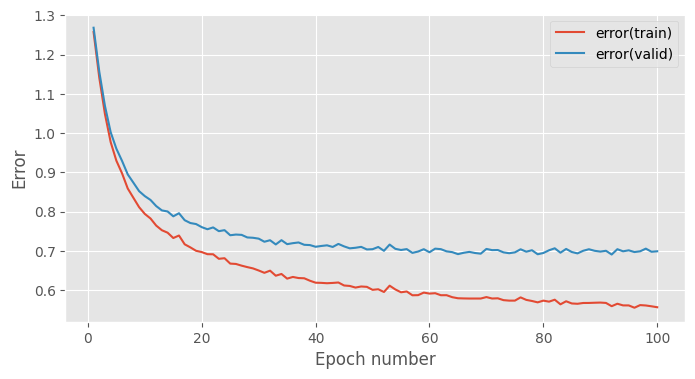

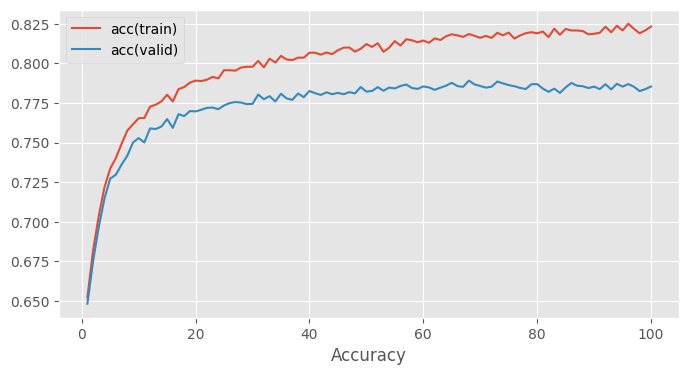

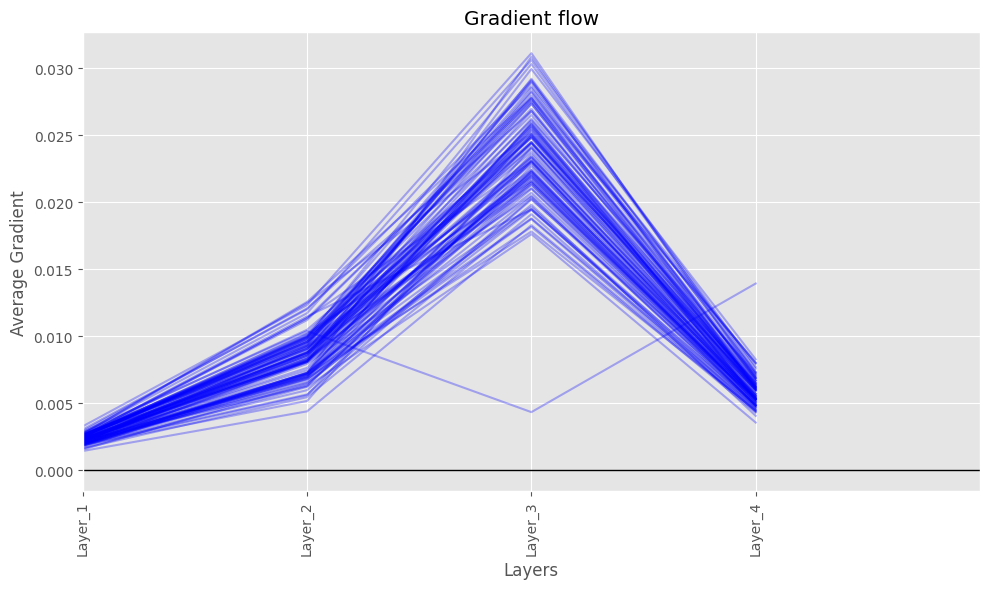

In [15]:
# Experimenting with different numbers of hidden units
hidden_units_list = [32, 64, 128]

# Store results
results_32 = None
results_64 = None
results_128 = None

# Train with 32 hidden units
print("Training with 32 hidden units")
train_data.reset()
valid_data.reset()

hidden_dim = 32
layer1 = AffineLayer(input_dim, hidden_dim, weights_init, biases_init)
activation1 = ReluLayer()
layer2 = AffineLayer(hidden_dim, output_dim, weights_init, biases_init)

layers = [layer1, activation1, layer2]
model = MultipleLayerModel(layers)

error = CrossEntropySoftmaxError()
learning_rule = AdamLearningRule(learning_rate=0.001)

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, 100, 1, notebook=False)

results_32 = {}
results_32['stats'] = stats
results_32['keys'] = keys

fig_1.savefig('width_32units_error.pdf')
fig_2.savefig('width_32units_accuracy.pdf')

print("Final training error:", stats[-1, keys['error(train)']])
print("Final validation error:", stats[-1, keys['error(valid)']])
print("Final training accuracy:", stats[-1, keys['acc(train)']])
print("Final validation accuracy:", stats[-1, keys['acc(valid)']])

Training with 64 hidden units


Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 324.20it/s]
Epoch 1: 3.1s to complete
    error(train)=1.08e+00, acc(train)=6.93e-01, error(valid)=1.09e+00, acc(valid)=6.88e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 293.21it/s]
Epoch 2: 3.4s to complete
    error(train)=8.81e-01, acc(train)=7.45e-01, error(valid)=9.03e-01, acc(valid)=7.40e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 275.40it/s]
Epoch 3: 3.6s to complete
    error(train)=7.70e-01, acc(train)=7.73e-01, error(valid)=8.00e-01, acc(valid)=7.67e-01
Ep Prog: 100%|██████████| 1000/1000 [00:02<00:00, 352.80it/s]
Epoch 4: 2.8s to complete
    error(train)=7.10e-01, acc(train)=7.87e-01, error(valid)=7.46e-01, acc(valid)=7.77e-01
Ep Prog: 100%|██████████| 1000/1000 [00:02<00:00, 410.32it/s]
Epoch 5: 2.4s to complete
    error(train)=6.70e-01, acc(train)=7.95e-01, error(valid)=7.13e-01, acc(valid)=7.84e-01
Ep Prog: 100%|██████████| 1000/1000 [00:02<00:00, 457.29it/s]
Epoch 6: 2.2s to complete
    error(train)=

Final training error: 0.33253511496631943
Final validation error: 0.6723729374731489
Final training accuracy: 0.8855399999999967
Final validation accuracy: 0.8086075949367088


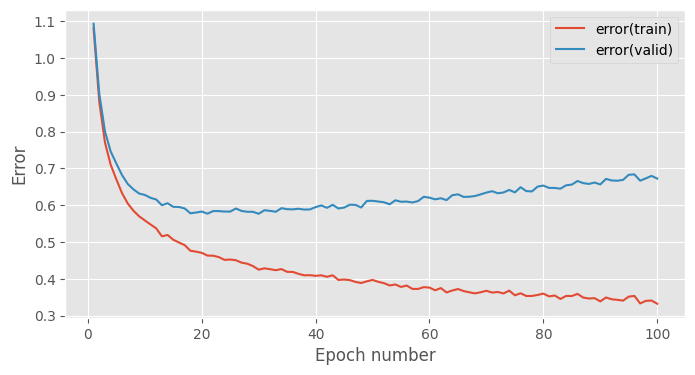

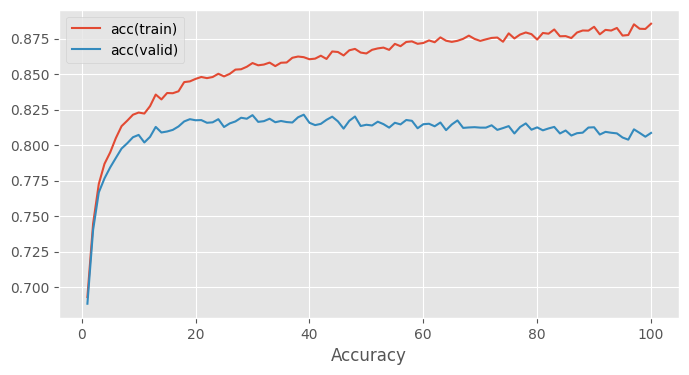

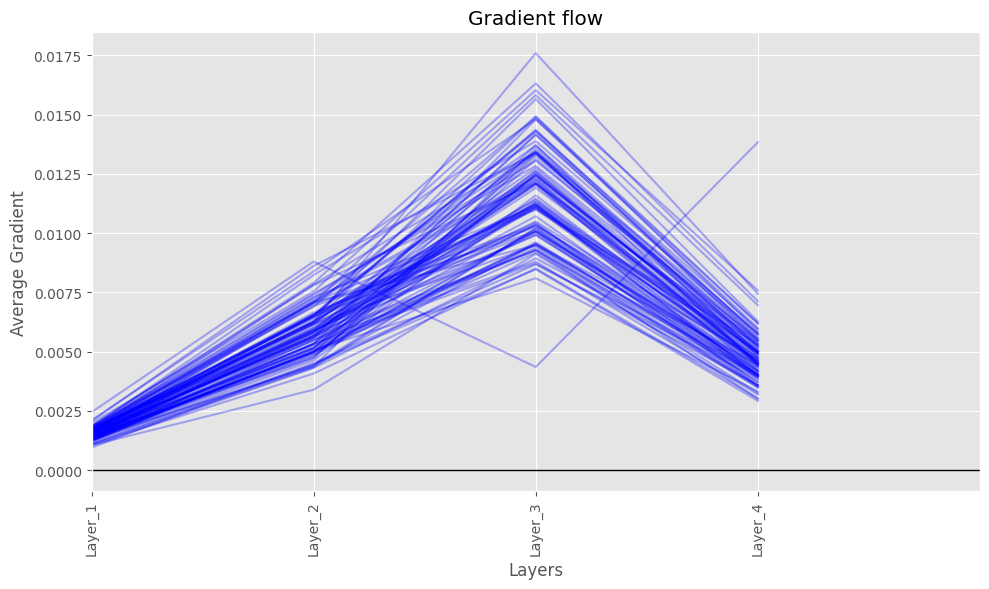

In [16]:
# 64 hidden units
print("Training with 64 hidden units")
train_data.reset()
valid_data.reset()

hidden_dim = 64
layer1 = AffineLayer(input_dim, hidden_dim, weights_init, biases_init)
activation1 = ReluLayer()
layer2 = AffineLayer(hidden_dim, output_dim, weights_init, biases_init)

layers = [layer1, activation1, layer2]
model = MultipleLayerModel(layers)

error = CrossEntropySoftmaxError()
learning_rule = AdamLearningRule(learning_rate=0.001)

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, 100, 1, notebook=False)

results_64 = {}
results_64['stats'] = stats
results_64['keys'] = keys

fig_1.savefig('width_64units_error.pdf')
fig_2.savefig('width_64units_accuracy.pdf')

print("Final training error:", stats[-1, keys['error(train)']])
print("Final validation error:", stats[-1, keys['error(valid)']])
print("Final training accuracy:", stats[-1, keys['acc(train)']])
print("Final validation accuracy:", stats[-1, keys['acc(valid)']])

Training with 128 hidden units


Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 205.16it/s]
Epoch 1: 4.9s to complete
    error(train)=9.25e-01, acc(train)=7.31e-01, error(valid)=9.40e-01, acc(valid)=7.23e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 167.80it/s]
Epoch 2: 6.0s to complete
    error(train)=7.06e-01, acc(train)=7.87e-01, error(valid)=7.36e-01, acc(valid)=7.78e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 178.05it/s]
Epoch 3: 5.6s to complete
    error(train)=6.15e-01, acc(train)=8.10e-01, error(valid)=6.57e-01, acc(valid)=7.94e-01
Ep Prog: 100%|██████████| 1000/1000 [00:06<00:00, 164.44it/s]
Epoch 4: 6.1s to complete
    error(train)=5.54e-01, acc(train)=8.25e-01, error(valid)=6.11e-01, acc(valid)=8.08e-01
Ep Prog: 100%|██████████| 1000/1000 [00:06<00:00, 160.61it/s]
Epoch 5: 6.2s to complete
    error(train)=5.12e-01, acc(train)=8.37e-01, error(valid)=5.78e-01, acc(valid)=8.16e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 176.52it/s]
Epoch 6: 5.7s to complete
    error(train)=

Final training error: 0.1552404452198314
Final validation error: 0.9788238202236513
Final training accuracy: 0.9408000000000039
Final validation accuracy: 0.8084177215189876


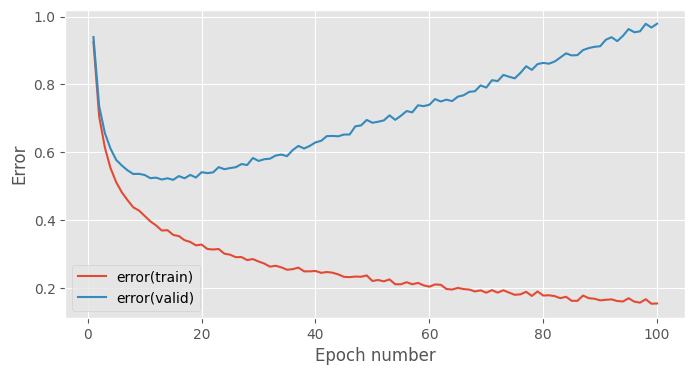

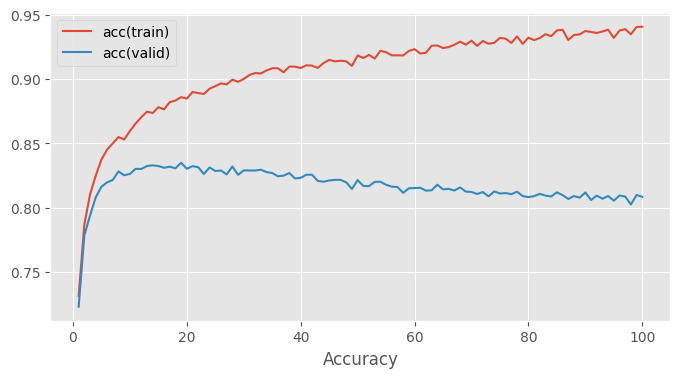

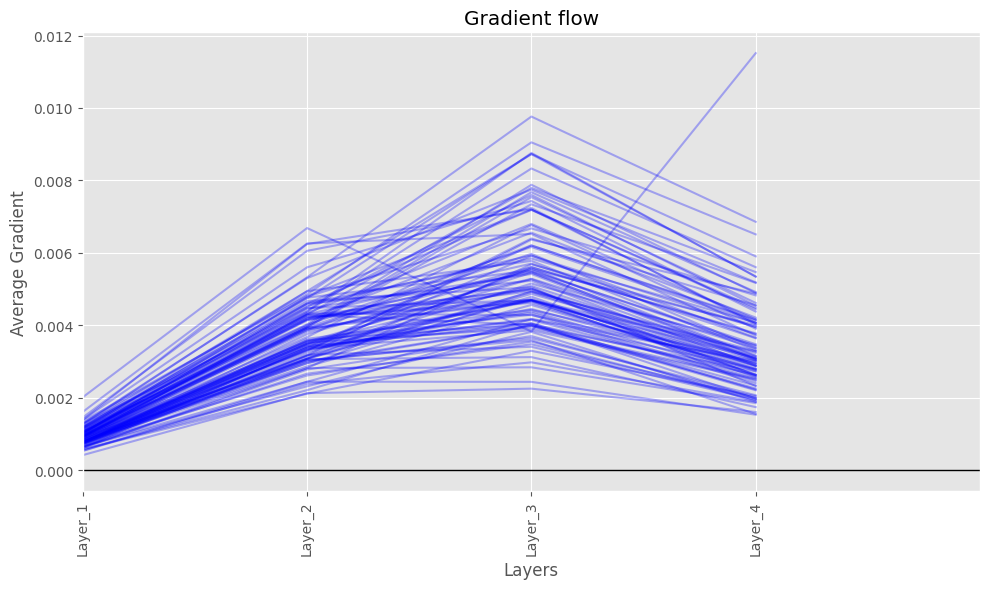

In [17]:
# 128 hidden units
print("Training with 128 hidden units")
train_data.reset()
valid_data.reset()

hidden_dim = 128
layer1 = AffineLayer(input_dim, hidden_dim, weights_init, biases_init)
activation1 = ReluLayer()
layer2 = AffineLayer(hidden_dim, output_dim, weights_init, biases_init)

layers = [layer1, activation1, layer2]
model = MultipleLayerModel(layers)

error = CrossEntropySoftmaxError()
learning_rule = AdamLearningRule(learning_rate=0.001)

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, 100, 1, notebook=False)

results_128 = {}
results_128['stats'] = stats
results_128['keys'] = keys

fig_1.savefig('width_128units_error.pdf')
fig_2.savefig('width_128units_accuracy.pdf')

print("Final training error:", stats[-1, keys['error(train)']])
print("Final validation error:", stats[-1, keys['error(valid)']])
print("Final training accuracy:", stats[-1, keys['acc(train)']])
print("Final validation accuracy:", stats[-1, keys['acc(valid)']])

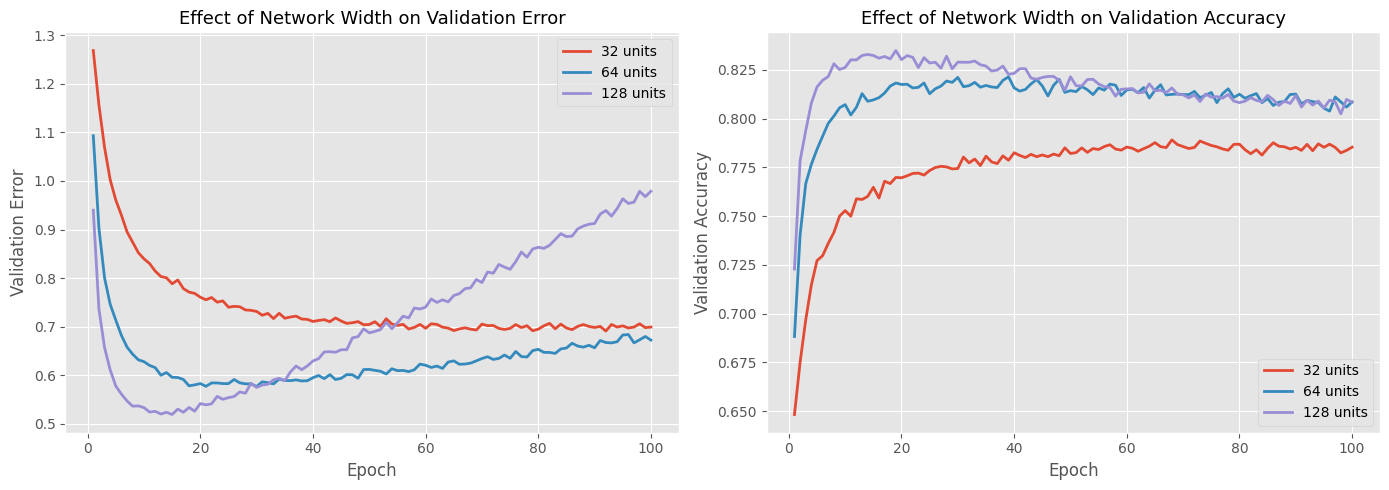

In [18]:
# comparison plots
fig = plt.figure(figsize=(14, 5))

# validation errors
ax1 = fig.add_subplot(1, 2, 1)

stats_32 = results_32['stats']
keys_32 = results_32['keys']
epochs_32 = np.arange(1, stats_32.shape[0])
valid_error_32 = stats_32[1:, keys_32['error(valid)']]
ax1.plot(epochs_32, valid_error_32, label='32 units', linewidth=2)

stats_64 = results_64['stats']
keys_64 = results_64['keys']
epochs_64 = np.arange(1, stats_64.shape[0])
valid_error_64 = stats_64[1:, keys_64['error(valid)']]
ax1.plot(epochs_64, valid_error_64, label='64 units', linewidth=2)

stats_128 = results_128['stats']
keys_128 = results_128['keys']
epochs_128 = np.arange(1, stats_128.shape[0])
valid_error_128 = stats_128[1:, keys_128['error(valid)']]
ax1.plot(epochs_128, valid_error_128, label='128 units', linewidth=2)

ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Validation Error', fontsize=12)
ax1.set_title('Effect of Network Width on Validation Error', fontsize=13)
ax1.legend()
ax1.grid(True)

# validation accuracies
ax2 = fig.add_subplot(1, 2, 2)

valid_acc_32 = stats_32[1:, keys_32['acc(valid)']]
ax2.plot(epochs_32, valid_acc_32, label='32 units', linewidth=2)

valid_acc_64 = stats_64[1:, keys_64['acc(valid)']]
ax2.plot(epochs_64, valid_acc_64, label='64 units', linewidth=2)

valid_acc_128 = stats_128[1:, keys_128['acc(valid)']]
ax2.plot(epochs_128, valid_acc_128, label='128 units', linewidth=2)

ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy', fontsize=12)
ax2.set_title('Effect of Network Width on Validation Accuracy', fontsize=13)
ax2.legend()
ax2.grid(True)

fig.tight_layout()
fig.savefig('width_comparison.pdf')
plt.show()

Training with 1 hidden layer


Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 207.27it/s]
Epoch 1: 4.8s to complete
    error(train)=8.92e-01, acc(train)=7.43e-01, error(valid)=9.11e-01, acc(valid)=7.39e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 206.10it/s]
Epoch 2: 4.9s to complete
    error(train)=7.13e-01, acc(train)=7.83e-01, error(valid)=7.47e-01, acc(valid)=7.71e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 194.72it/s]
Epoch 3: 5.1s to complete
    error(train)=6.21e-01, acc(train)=8.07e-01, error(valid)=6.66e-01, acc(valid)=7.94e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 191.94it/s]
Epoch 4: 5.2s to complete
    error(train)=5.45e-01, acc(train)=8.30e-01, error(valid)=5.97e-01, acc(valid)=8.16e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 204.22it/s]
Epoch 5: 4.9s to complete
    error(train)=5.12e-01, acc(train)=8.36e-01, error(valid)=5.81e-01, acc(valid)=8.15e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 196.75it/s]
Epoch 6: 5.1s to complete
    error(train)=

Final training error: 0.156374451502878
Final validation error: 0.9508866378070486
Final training accuracy: 0.9393200000000046
Final validation accuracy: 0.8067721518987341


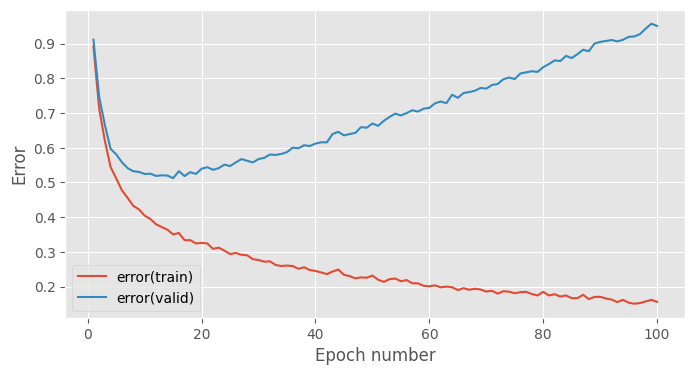

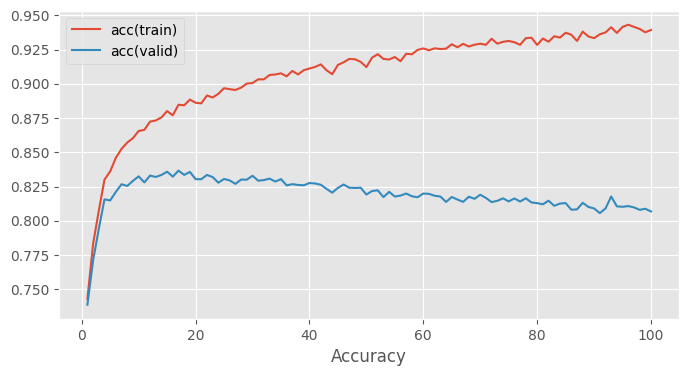

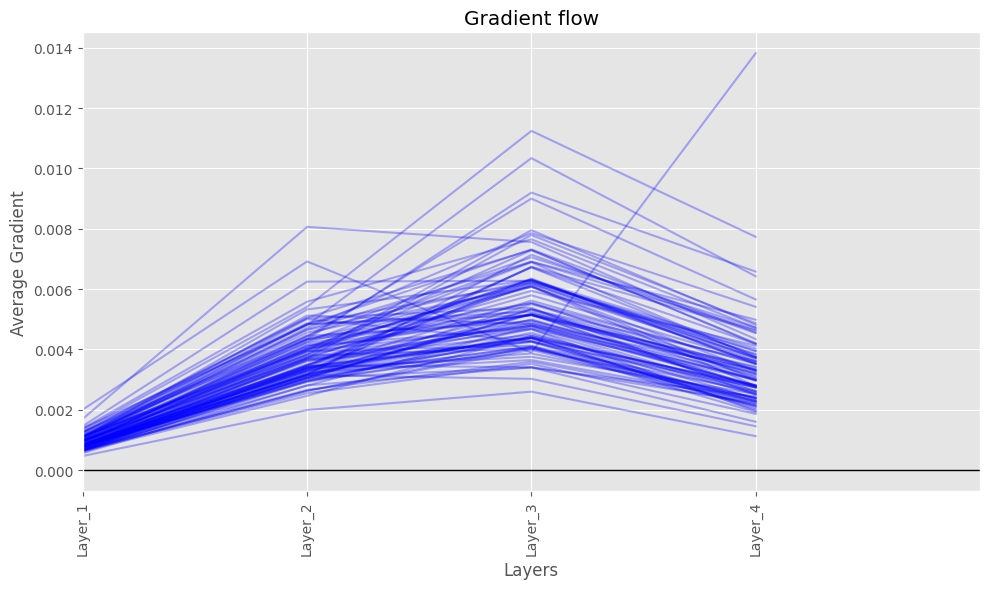

In [19]:
# 1 hidden layer
print("Training with 1 hidden layer")
train_data.reset()
valid_data.reset()

layer1 = AffineLayer(input_dim, 128, weights_init, biases_init)
activation1 = ReluLayer()
layer_out = AffineLayer(128, output_dim, weights_init, biases_init)

layers = [layer1, activation1, layer_out]
model = MultipleLayerModel(layers)

error = CrossEntropySoftmaxError()
learning_rule = AdamLearningRule(learning_rate=0.001)

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, 100, 1, notebook=False)

results_1layer = {}
results_1layer['stats'] = stats
results_1layer['keys'] = keys

fig_1.savefig('depth_1layer_error.pdf')
fig_2.savefig('depth_1layer_accuracy.pdf')

print("Final training error:", stats[-1, keys['error(train)']])
print("Final validation error:", stats[-1, keys['error(valid)']])
print("Final training accuracy:", stats[-1, keys['acc(train)']])
print("Final validation accuracy:", stats[-1, keys['acc(valid)']])

Training with 2 hidden layers


Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 216.08it/s]
Epoch 1: 4.6s to complete
    error(train)=7.43e-01, acc(train)=7.75e-01, error(valid)=7.70e-01, acc(valid)=7.66e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 233.94it/s]
Epoch 2: 4.3s to complete
    error(train)=5.85e-01, acc(train)=8.13e-01, error(valid)=6.23e-01, acc(valid)=8.02e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 192.83it/s]
Epoch 3: 5.2s to complete
    error(train)=4.91e-01, acc(train)=8.39e-01, error(valid)=5.51e-01, acc(valid)=8.22e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 198.35it/s]
Epoch 4: 5.1s to complete
    error(train)=4.55e-01, acc(train)=8.48e-01, error(valid)=5.28e-01, acc(valid)=8.29e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 204.35it/s]
Epoch 5: 4.9s to complete
    error(train)=4.31e-01, acc(train)=8.53e-01, error(valid)=5.22e-01, acc(valid)=8.27e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 200.41it/s]
Epoch 6: 5.0s to complete
    error(train)=

Final training error: 0.10561672197033299
Final validation error: 1.5870938032090391
Final training accuracy: 0.9567600000000125
Final validation accuracy: 0.8128481012658226


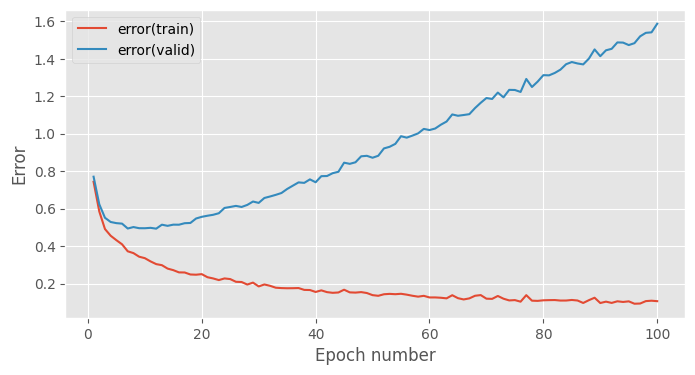

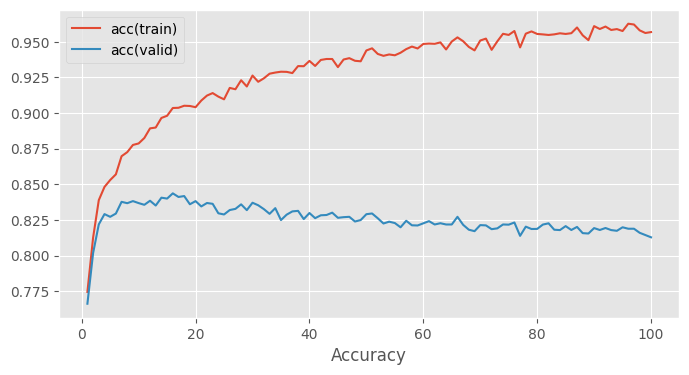

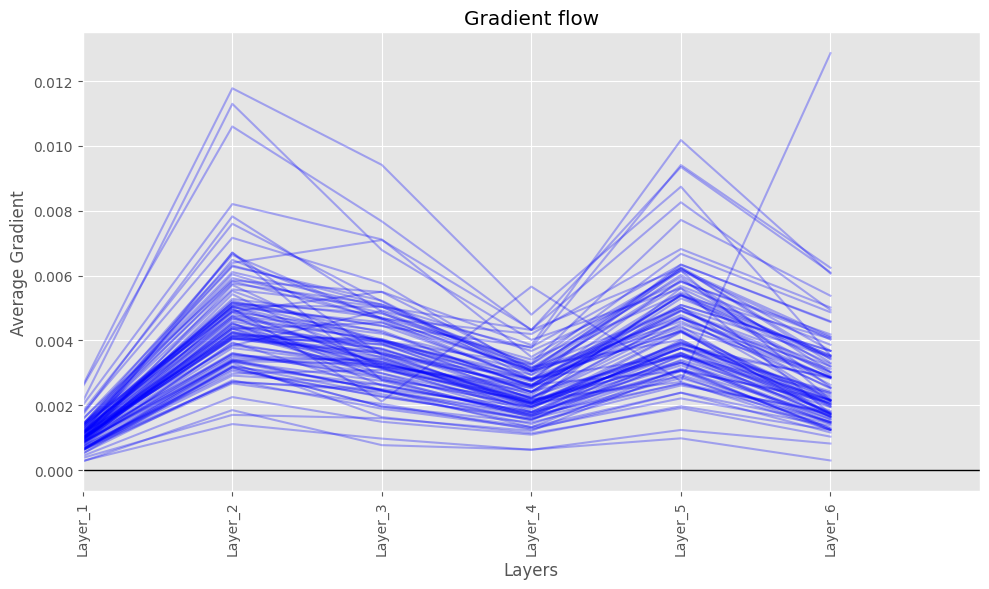

In [20]:
# 2 hidden layers
print("Training with 2 hidden layers")
train_data.reset()
valid_data.reset()

layer1 = AffineLayer(input_dim, 128, weights_init, biases_init)
activation1 = ReluLayer()
layer2 = AffineLayer(128, 128, weights_init, biases_init)
activation2 = ReluLayer()
layer_out = AffineLayer(128, output_dim, weights_init, biases_init)

layers = [layer1, activation1, layer2, activation2, layer_out]
model = MultipleLayerModel(layers)

error = CrossEntropySoftmaxError()
learning_rule = AdamLearningRule(learning_rate=0.001)

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, 100, 1, notebook=False)

results_2layer = {}
results_2layer['stats'] = stats
results_2layer['keys'] = keys

fig_1.savefig('depth_2layer_error.pdf')
fig_2.savefig('depth_2layer_accuracy.pdf')

print("Final training error:", stats[-1, keys['error(train)']])
print("Final validation error:", stats[-1, keys['error(valid)']])
print("Final training accuracy:", stats[-1, keys['acc(train)']])
print("Final validation accuracy:", stats[-1, keys['acc(valid)']])

Training with 3 hidden layers


Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 301.30it/s]
Epoch 1: 3.3s to complete
    error(train)=7.02e-01, acc(train)=7.77e-01, error(valid)=7.31e-01, acc(valid)=7.71e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 298.89it/s]
Epoch 2: 3.4s to complete
    error(train)=5.43e-01, acc(train)=8.21e-01, error(valid)=5.92e-01, acc(valid)=8.05e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 295.68it/s]
Epoch 3: 3.4s to complete
    error(train)=4.90e-01, acc(train)=8.34e-01, error(valid)=5.62e-01, acc(valid)=8.14e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 302.74it/s]
Epoch 4: 3.3s to complete
    error(train)=4.49e-01, acc(train)=8.44e-01, error(valid)=5.39e-01, acc(valid)=8.20e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 306.97it/s]
Epoch 5: 3.3s to complete
    error(train)=4.04e-01, acc(train)=8.58e-01, error(valid)=5.09e-01, acc(valid)=8.32e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 315.28it/s]
Epoch 6: 3.2s to complete
    error(train)=

Final training error: 0.11213732181771405
Final validation error: 1.6629646702831318
Final training accuracy: 0.9579300000000126
Final validation accuracy: 0.8195569620253161


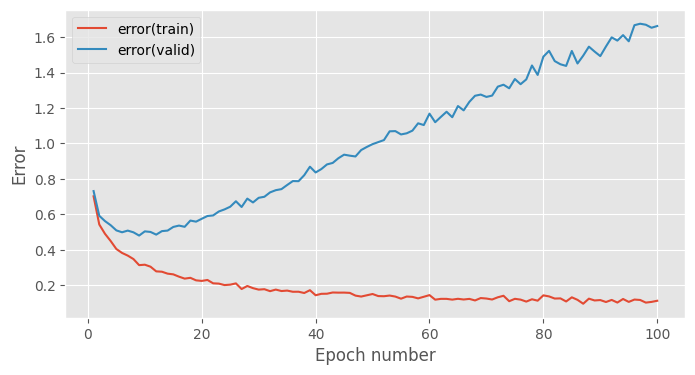

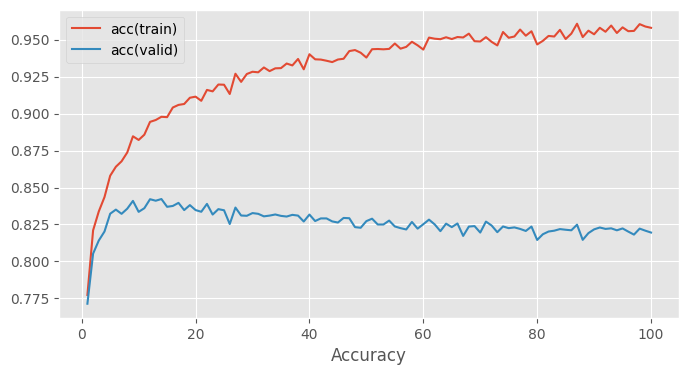

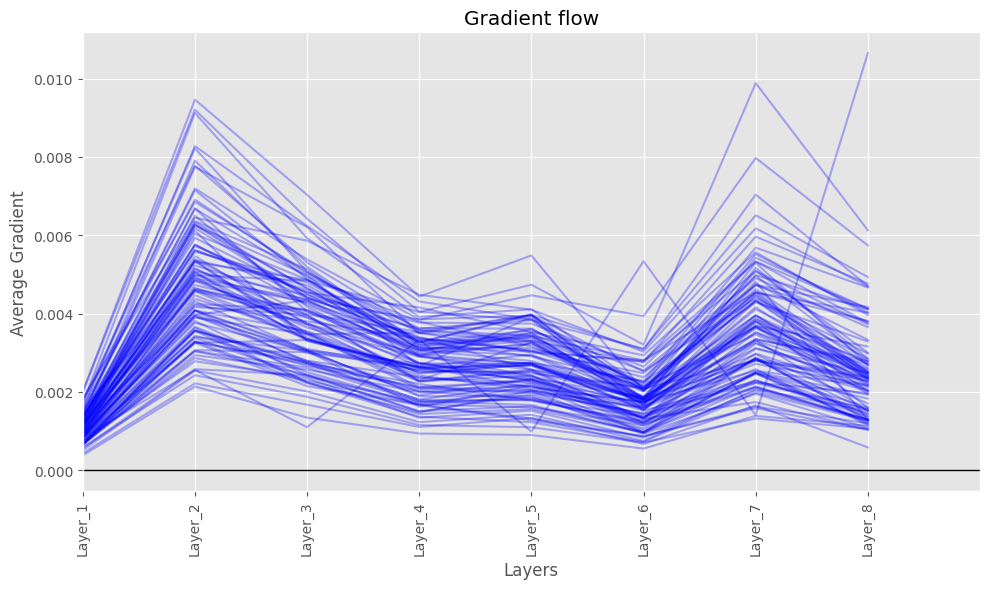

In [21]:
# 3 hidden layers
print("Training with 3 hidden layers")
train_data.reset()
valid_data.reset()

layer1 = AffineLayer(input_dim, 128, weights_init, biases_init)
activation1 = ReluLayer()
layer2 = AffineLayer(128, 128, weights_init, biases_init)
activation2 = ReluLayer()
layer3 = AffineLayer(128, 128, weights_init, biases_init)
activation3 = ReluLayer()
layer_out = AffineLayer(128, output_dim, weights_init, biases_init)

layers = [layer1, activation1, layer2, activation2, layer3, activation3, layer_out]
model = MultipleLayerModel(layers)

error = CrossEntropySoftmaxError()
learning_rule = AdamLearningRule(learning_rate=0.001)

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, 100, 1, notebook=False)

results_3layer = {}
results_3layer['stats'] = stats
results_3layer['keys'] = keys

fig_1.savefig('depth_3layer_error.pdf')
fig_2.savefig('depth_3layer_accuracy.pdf')

print("Final training error:", stats[-1, keys['error(train)']])
print("Final validation error:", stats[-1, keys['error(valid)']])
print("Final training accuracy:", stats[-1, keys['acc(train)']])
print("Final validation accuracy:", stats[-1, keys['acc(valid)']])

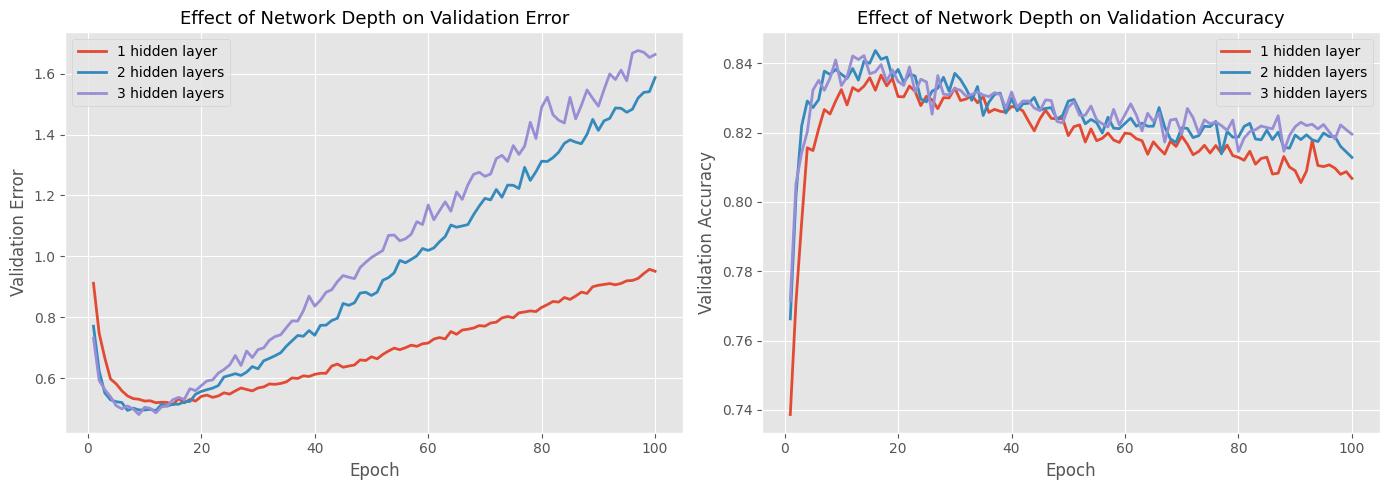

In [22]:
# comparison plot
fig = plt.figure(figsize=(14, 5))

# validation errors
ax1 = fig.add_subplot(1, 2, 1)

stats_1 = results_1layer['stats']
keys_1 = results_1layer['keys']
epochs_1 = np.arange(1, stats_1.shape[0])
valid_error_1 = stats_1[1:, keys_1['error(valid)']]
ax1.plot(epochs_1, valid_error_1, label='1 hidden layer', linewidth=2)

stats_2 = results_2layer['stats']
keys_2 = results_2layer['keys']
epochs_2 = np.arange(1, stats_2.shape[0])
valid_error_2 = stats_2[1:, keys_2['error(valid)']]
ax1.plot(epochs_2, valid_error_2, label='2 hidden layers', linewidth=2)

stats_3 = results_3layer['stats']
keys_3 = results_3layer['keys']
epochs_3 = np.arange(1, stats_3.shape[0])
valid_error_3 = stats_3[1:, keys_3['error(valid)']]
ax1.plot(epochs_3, valid_error_3, label='3 hidden layers', linewidth=2)

ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Validation Error', fontsize=12)
ax1.set_title('Effect of Network Depth on Validation Error', fontsize=13)
ax1.legend()
ax1.grid(True)

# validation accuracies
ax2 = fig.add_subplot(1, 2, 2)

valid_acc_1 = stats_1[1:, keys_1['acc(valid)']]
ax2.plot(epochs_1, valid_acc_1, label='1 hidden layer', linewidth=2)

valid_acc_2 = stats_2[1:, keys_2['acc(valid)']]
ax2.plot(epochs_2, valid_acc_2, label='2 hidden layers', linewidth=2)

valid_acc_3 = stats_3[1:, keys_3['acc(valid)']]
ax2.plot(epochs_3, valid_acc_3, label='3 hidden layers', linewidth=2)

ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy', fontsize=12)
ax2.set_title('Effect of Network Depth on Validation Accuracy', fontsize=13)
ax2.legend()
ax2.grid(True)

fig.tight_layout()
fig.savefig('depth_comparison.pdf')
plt.show()

In [23]:
print("Width Experiments Results")
print("Number of Hidden Units  |Val. Acc. |Train Error| Val. Error")



# Get results for 32 units
val_acc_32 = results_32['stats'][-1, results_32['keys']['acc(valid)']]
train_err_32 = results_32['stats'][-1, results_32['keys']['error(train)']]
val_err_32 = results_32['stats'][-1, results_32['keys']['error(valid)']]

# Convert to percentage and format
val_acc_32_percent = val_acc_32 * 100
print("32 units                |   {:.1f}   |  {:.3f}  |   {:.3f}".format(
    val_acc_32_percent, train_err_32, val_err_32))

# Get results for 64 units
val_acc_64 = results_64['stats'][-1, results_64['keys']['acc(valid)']]
train_err_64 = results_64['stats'][-1, results_64['keys']['error(train)']]
val_err_64 = results_64['stats'][-1, results_64['keys']['error(valid)']]

val_acc_64_percent = val_acc_64 * 100
print("64 units                |   {:.1f}   |  {:.3f}  |   {:.3f}".format(
    val_acc_64_percent, train_err_64, val_err_64))

# Get results for 128 units
val_acc_128 = results_128['stats'][-1, results_128['keys']['acc(valid)']]
train_err_128 = results_128['stats'][-1, results_128['keys']['error(train)']]
val_err_128 = results_128['stats'][-1, results_128['keys']['error(valid)']]

val_acc_128_percent = val_acc_128 * 100
print("128 units               |   {:.1f}   |  {:.3f}  |   {:.3f}".format(
    val_acc_128_percent, train_err_128, val_err_128))

Width Experiments Results
Number of Hidden Units  |Val. Acc. |Train Error| Val. Error
32 units                |   78.5   |  0.557  |   0.699
64 units                |   80.9   |  0.333  |   0.672
128 units               |   80.8   |  0.155  |   0.979


In [24]:
print("Depth Experiments Results")
print("Number of Hidden Layers | Val. Acc.|Train Error| Val. Error")

# Get results for 1 layer
val_acc_1 = results_1layer['stats'][-1, results_1layer['keys']['acc(valid)']]
train_err_1 = results_1layer['stats'][-1, results_1layer['keys']['error(train)']]
val_err_1 = results_1layer['stats'][-1, results_1layer['keys']['error(valid)']]

val_acc_1_percent = val_acc_1 * 100
print("1 hidden layer          |   {:.1f}   |  {:.3f}  |   {:.3f}".format(
    val_acc_1_percent, train_err_1, val_err_1))

# Get results for 2 layers
val_acc_2 = results_2layer['stats'][-1, results_2layer['keys']['acc(valid)']]
train_err_2 = results_2layer['stats'][-1, results_2layer['keys']['error(train)']]
val_err_2 = results_2layer['stats'][-1, results_2layer['keys']['error(valid)']]

val_acc_2_percent = val_acc_2 * 100
print("2 hidden layers         |   {:.1f}   |  {:.3f}  |   {:.3f}".format(
    val_acc_2_percent, train_err_2, val_err_2))

# Get results for 3 layers
val_acc_3 = results_3layer['stats'][-1, results_3layer['keys']['acc(valid)']]
train_err_3 = results_3layer['stats'][-1, results_3layer['keys']['error(train)']]
val_err_3 = results_3layer['stats'][-1, results_3layer['keys']['error(valid)']]

val_acc_3_percent = val_acc_3 * 100
print("3 hidden layers         |   {:.1f}   |  {:.3f}  |   {:.3f}".format(
    val_acc_3_percent, train_err_3, val_err_3))

Depth Experiments Results
Number of Hidden Layers | Val. Acc.|Train Error| Val. Error
1 hidden layer          |   80.7   |  0.156  |   0.951
2 hidden layers         |   81.3   |  0.106  |   1.587
3 hidden layers         |   82.0   |  0.112  |   1.663


## Problematic Training

The following experiments show a failed training run. Run the code and investigate the reasons.

Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 209.97it/s]
Epoch 1: 4.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 186.60it/s]
Epoch 2: 5.4s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.11e-02
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 212.14it/s]
Epoch 3: 4.7s to complete
    error(train)=3.84e+00, acc(train)=2.17e-02, error(valid)=3.84e+00, acc(valid)=1.98e-02
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 206.13it/s]
Epoch 4: 4.9s to complete
    error(train)=3.58e+00, acc(train)=5.21e-02, error(valid)=3.58e+00, acc(valid)=5.32e-02
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 212.24it/s]
Epoch 5: 4.7s to complete
    error(train)=3.42e+00, acc(train)=5.54e-02, error(valid)=3.42e+00, acc(valid)=5.26e-02
Exp Prog: 100%|██████████| 5/5 [00:32<00:00,  6.45s/it]


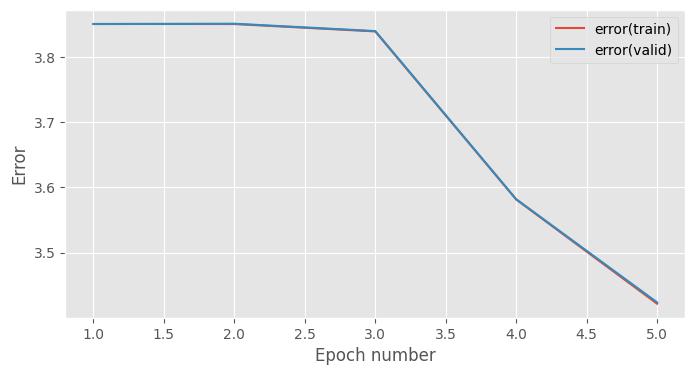

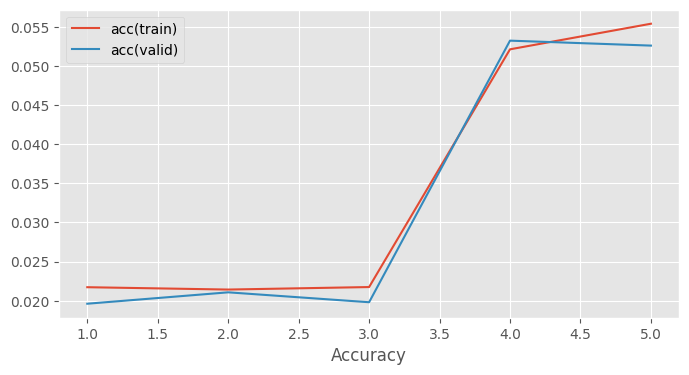

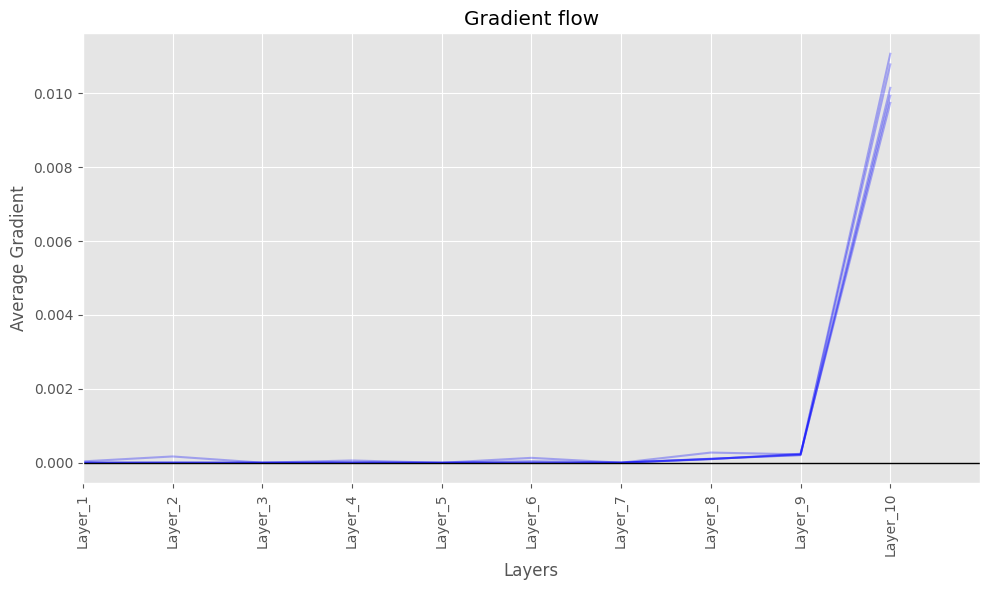

In [25]:
# Setup hyperparameters
learning_rate = 0.001
num_epochs = 5
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Create model with four hidden layer
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    CustomActivationLayer(), 
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    CustomActivationLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    CustomActivationLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    CustomActivationLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init) # output layer
])

error = CrossEntropySoftmaxError()
# Use a Adam learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate)

# Remember to use notebook=False when you write a script to be run in a terminal
stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=False)

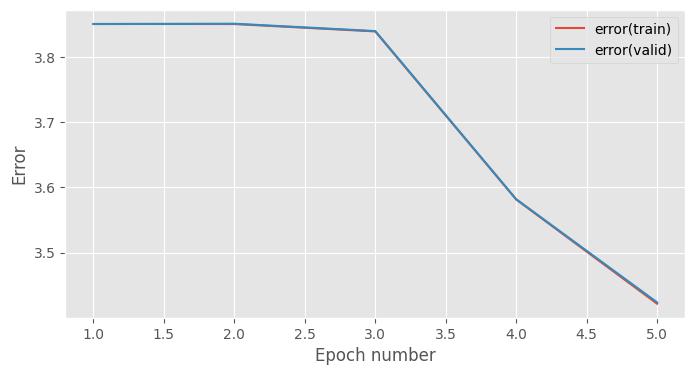

In [26]:
# You can then check the plots like this
fig_1 # The training error plot

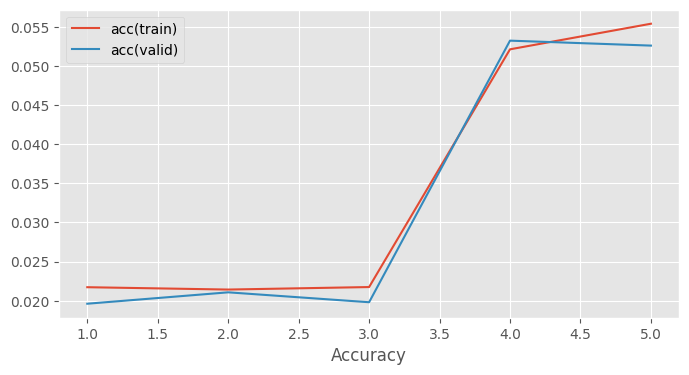

In [27]:
fig_2 # The training accuracy plot

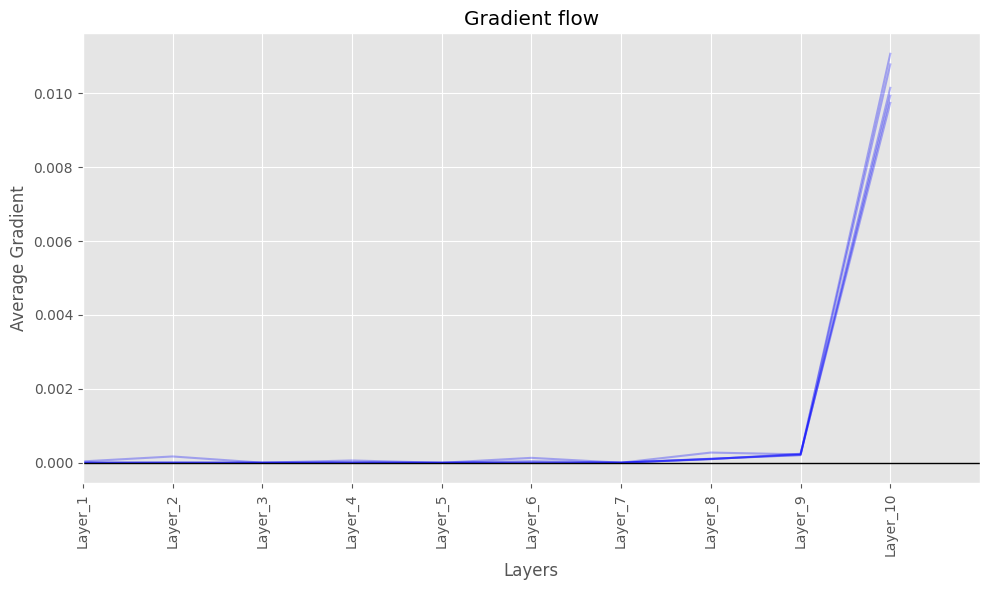

In [28]:
grad_plot # The gradient flow plot

Training baseline (3 hidden layers, 128 units, lr=0.0001)


Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 231.92it/s]
Epoch 1: 4.3s to complete
    error(train)=1.36e+00, acc(train)=6.25e-01, error(valid)=1.36e+00, acc(valid)=6.21e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 189.96it/s]
Epoch 2: 5.3s to complete
    error(train)=1.11e+00, acc(train)=6.87e-01, error(valid)=1.11e+00, acc(valid)=6.82e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 195.55it/s]
Epoch 3: 5.1s to complete
    error(train)=9.80e-01, acc(train)=7.20e-01, error(valid)=9.89e-01, acc(valid)=7.17e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 246.40it/s]
Epoch 4: 4.1s to complete
    error(train)=8.91e-01, acc(train)=7.41e-01, error(valid)=9.05e-01, acc(valid)=7.39e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 218.61it/s]
Epoch 5: 4.6s to complete
    error(train)=8.19e-01, acc(train)=7.60e-01, error(valid)=8.39e-01, acc(valid)=7.52e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 245.33it/s]
Epoch 6: 4.1s to complete
    error(train)=

Baseline - Valid Error: 0.5228496868988556
Baseline - Valid Acc: 0.8401898734177216


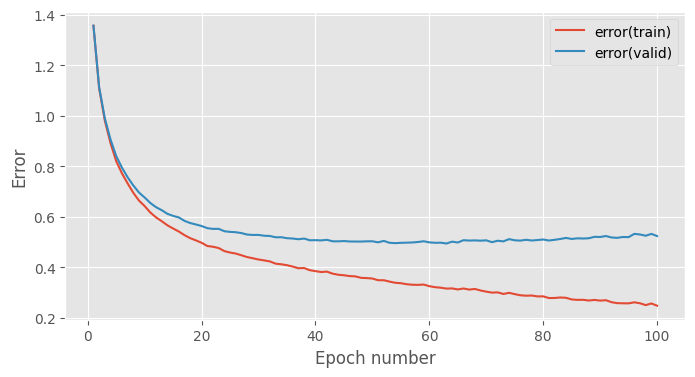

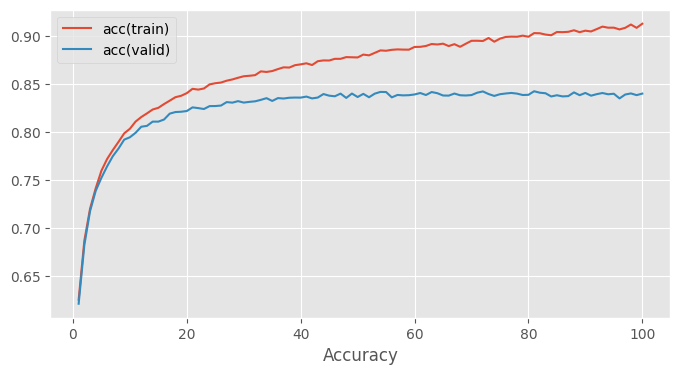

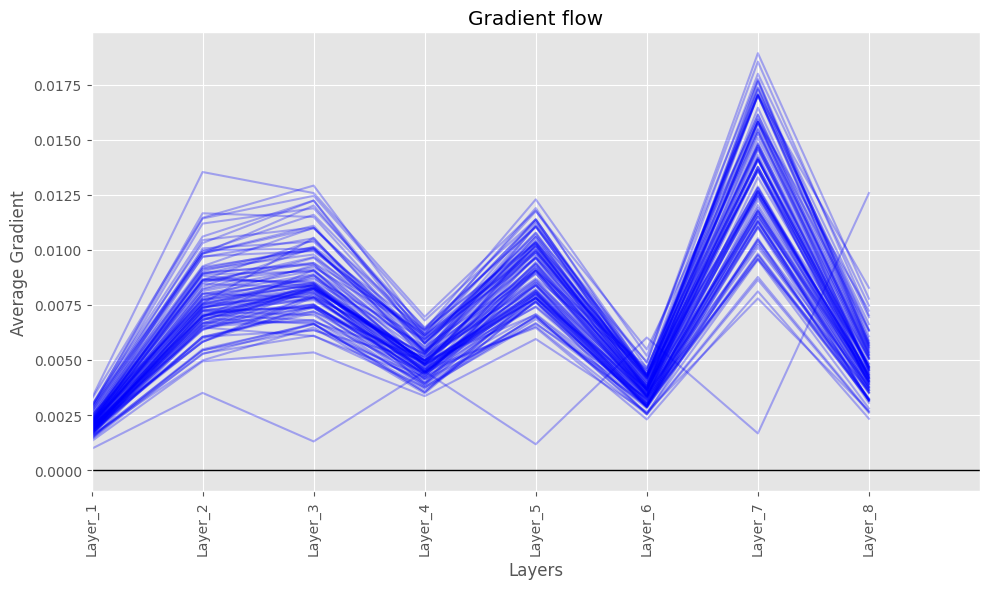

In [29]:
# Trainining baseline model for regularization experiments
print("Training baseline (3 hidden layers, 128 units, lr=0.0001)")

input_dim, output_dim, hidden_dim = 784, 47, 128

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

train_data.reset()
valid_data.reset()

layer1 = AffineLayer(input_dim, 128, weights_init, biases_init)
activation1 = ReluLayer()
layer2 = AffineLayer(128, 128, weights_init, biases_init)
activation2 = ReluLayer()
layer3 = AffineLayer(128, 128, weights_init, biases_init)
activation3 = ReluLayer()
layer_out = AffineLayer(128, output_dim, weights_init, biases_init)

layers = [layer1, activation1, layer2, activation2, layer3, activation3, layer_out]
model = MultipleLayerModel(layers)

error = CrossEntropySoftmaxError()
learning_rule = AdamLearningRule(learning_rate=0.0001)

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, 100, 1, notebook=False)

baseline_stats = stats
baseline_keys = keys

print("Baseline - Valid Error:", stats[-1, keys['error(valid)']])
print("Baseline - Valid Acc:", stats[-1, keys['acc(valid)']])

Training with Dropout (p=0.3)


Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 220.70it/s]
Epoch 1: 4.5s to complete
    error(train)=3.84e+00, acc(train)=7.91e-02, error(valid)=3.84e+00, acc(valid)=8.11e-02
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 221.43it/s]
Epoch 2: 4.5s to complete
    error(train)=3.69e+00, acc(train)=7.74e-02, error(valid)=3.69e+00, acc(valid)=7.72e-02
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 247.68it/s]
Epoch 3: 4.0s to complete
    error(train)=3.54e+00, acc(train)=1.16e-01, error(valid)=3.54e+00, acc(valid)=1.17e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 260.83it/s]
Epoch 4: 3.8s to complete
    error(train)=3.36e+00, acc(train)=1.61e-01, error(valid)=3.36e+00, acc(valid)=1.64e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 226.93it/s]
Epoch 5: 4.4s to complete
    error(train)=3.18e+00, acc(train)=1.81e-01, error(valid)=3.17e+00, acc(valid)=1.86e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 243.42it/s]
Epoch 6: 4.1s to complete
    error(train)=

Dropout 0.3 - Valid Error: 1.4631732872651322
Dropout 0.3 - Valid Acc: 0.6034177215189873


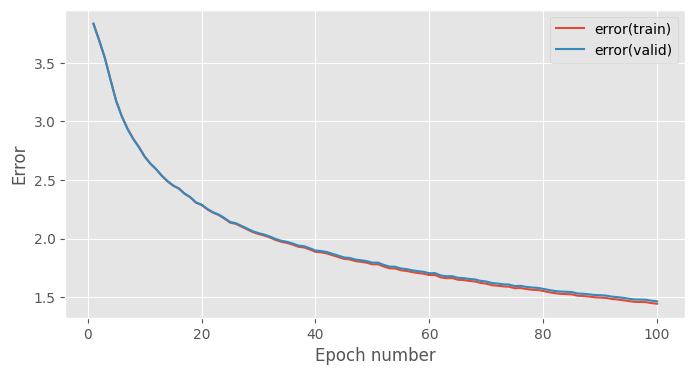

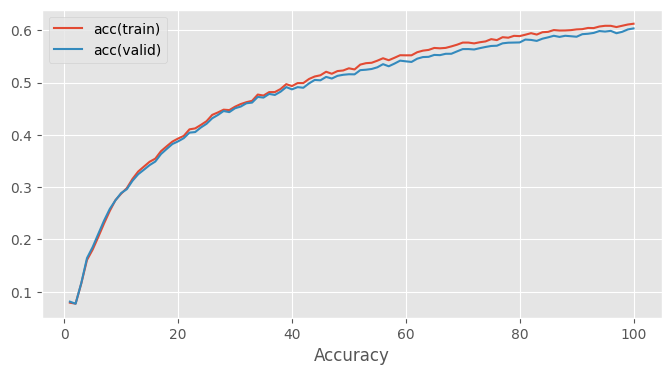

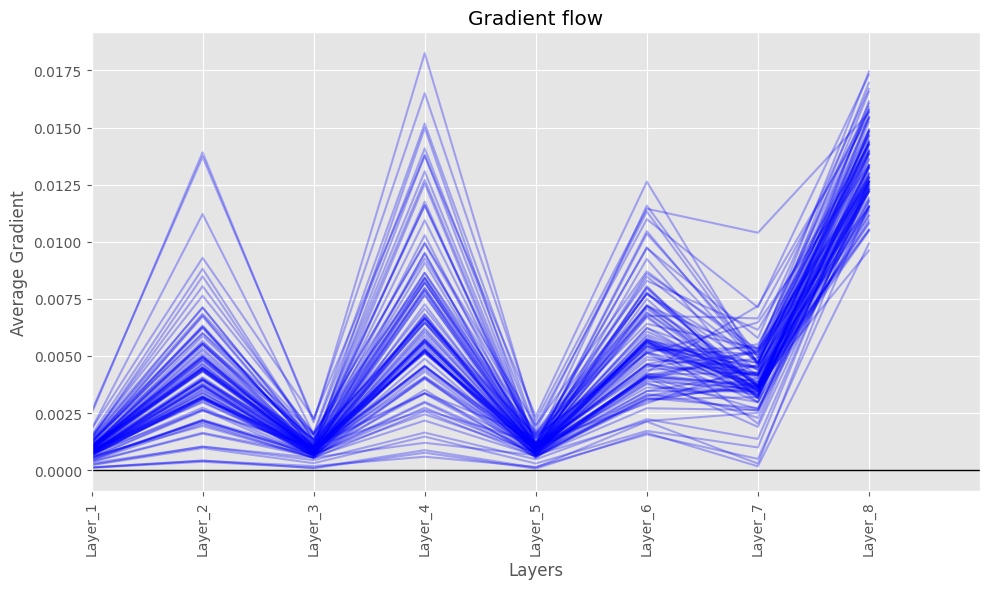

In [30]:
from mlp.layers import DropoutLayer

print("Training with Dropout (p=0.3)")
train_data.reset()
valid_data.reset()

input_dim, output_dim, hidden_dim = 784, 47, 128

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

layer1 = AffineLayer(input_dim, 128, weights_init, biases_init)
activation1 = ReluLayer()
dropout1 = DropoutLayer(rng=rng, incl_prob=0.3)

layer2 = AffineLayer(128, 128, weights_init, biases_init)
activation2 = ReluLayer()
dropout2 = DropoutLayer(rng=rng, incl_prob=0.3)

layer3 = AffineLayer(128, 128, weights_init, biases_init)
activation3 = ReluLayer()
dropout3 = DropoutLayer(rng=rng, incl_prob=0.3)

layer_out = AffineLayer(128, output_dim, weights_init, biases_init)

layers = [layer1, activation1, dropout1, layer2, activation2, dropout2, 
          layer3, activation3, dropout3, layer_out]
model = MultipleLayerModel(layers)

error = CrossEntropySoftmaxError()
learning_rule = AdamLearningRule(learning_rate=0.0001)

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, 100, 1, notebook=False)

dropout_03_stats = stats
dropout_03_keys = keys

print("Dropout 0.3 - Valid Error:", stats[-1, keys['error(valid)']])
print("Dropout 0.3 - Valid Acc:", stats[-1, keys['acc(valid)']])

Training with Dropout (p=0.5)


Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 245.14it/s]
Epoch 1: 4.1s to complete
    error(train)=3.41e+00, acc(train)=2.27e-01, error(valid)=3.40e+00, acc(valid)=2.30e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 248.98it/s]
Epoch 2: 4.0s to complete
    error(train)=2.67e+00, acc(train)=3.65e-01, error(valid)=2.66e+00, acc(valid)=3.63e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 262.95it/s]
Epoch 3: 3.8s to complete
    error(train)=2.31e+00, acc(train)=4.33e-01, error(valid)=2.31e+00, acc(valid)=4.34e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 246.64it/s]
Epoch 4: 4.1s to complete
    error(train)=2.08e+00, acc(train)=4.77e-01, error(valid)=2.08e+00, acc(valid)=4.75e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 227.30it/s]
Epoch 5: 4.4s to complete
    error(train)=1.92e+00, acc(train)=5.11e-01, error(valid)=1.92e+00, acc(valid)=5.11e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 258.48it/s]
Epoch 6: 3.9s to complete
    error(train)=

Dropout 0.5 - Valid Error: 0.721587365532935
Dropout 0.5 - Valid Acc: 0.7674683544303796


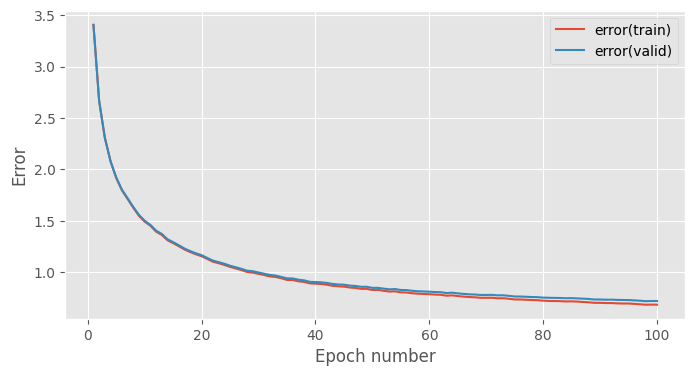

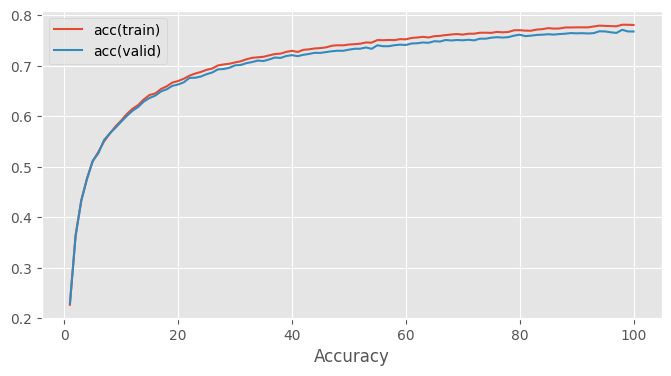

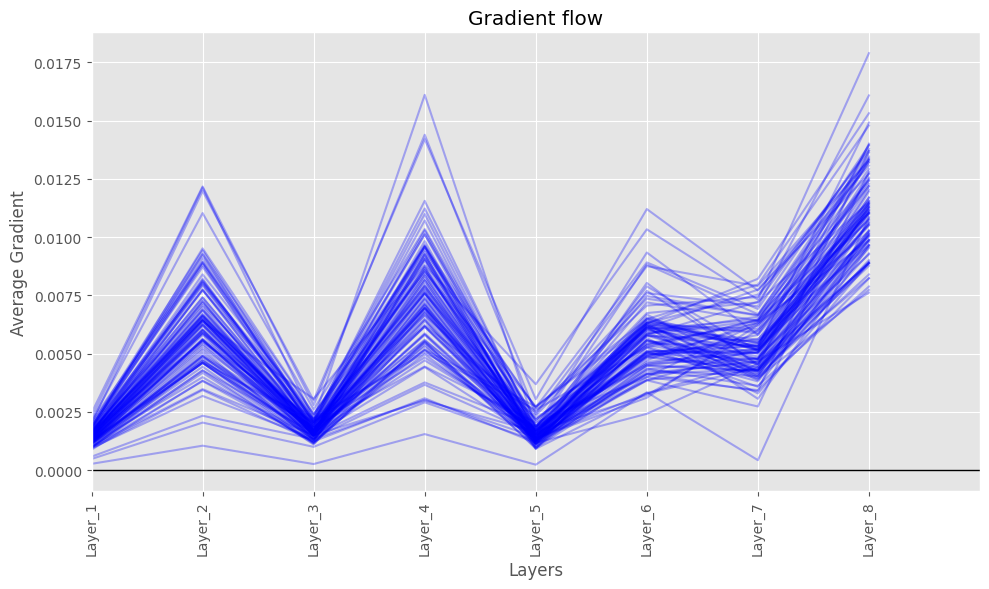

In [31]:
print("Training with Dropout (p=0.5)")
train_data.reset()
valid_data.reset()

layer1 = AffineLayer(input_dim, 128, weights_init, biases_init)
activation1 = ReluLayer()
dropout1 = DropoutLayer(rng=rng, incl_prob=0.5)

layer2 = AffineLayer(128, 128, weights_init, biases_init)
activation2 = ReluLayer()
dropout2 = DropoutLayer(rng=rng, incl_prob=0.5)

layer3 = AffineLayer(128, 128, weights_init, biases_init)
activation3 = ReluLayer()
dropout3 = DropoutLayer(rng=rng, incl_prob=0.5)

layer_out = AffineLayer(128, output_dim, weights_init, biases_init)

layers = [layer1, activation1, dropout1, layer2, activation2, dropout2, 
          layer3, activation3, dropout3, layer_out]
model = MultipleLayerModel(layers)

error = CrossEntropySoftmaxError()
learning_rule = AdamLearningRule(learning_rate=0.0001)

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, 100, 1, notebook=False)

dropout_05_stats = stats
dropout_05_keys = keys

print("Dropout 0.5 - Valid Error:", stats[-1, keys['error(valid)']])
print("Dropout 0.5 - Valid Acc:", stats[-1, keys['acc(valid)']])

Training with Dropout (p=0.7)


Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 201.47it/s]
Epoch 1: 5.0s to complete
    error(train)=2.40e+00, acc(train)=4.33e-01, error(valid)=2.40e+00, acc(valid)=4.33e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 223.80it/s]
Epoch 2: 4.5s to complete
    error(train)=1.79e+00, acc(train)=5.45e-01, error(valid)=1.79e+00, acc(valid)=5.46e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 217.06it/s]
Epoch 3: 4.6s to complete
    error(train)=1.53e+00, acc(train)=6.00e-01, error(valid)=1.53e+00, acc(valid)=5.94e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 260.60it/s]
Epoch 4: 3.8s to complete
    error(train)=1.38e+00, acc(train)=6.30e-01, error(valid)=1.38e+00, acc(valid)=6.24e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 240.98it/s]
Epoch 5: 4.2s to complete
    error(train)=1.26e+00, acc(train)=6.52e-01, error(valid)=1.26e+00, acc(valid)=6.46e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 224.45it/s]
Epoch 6: 4.5s to complete
    error(train)=

Dropout 0.7 - Valid Error: 0.5027972480316647
Dropout 0.7 - Valid Acc: 0.8306329113924044


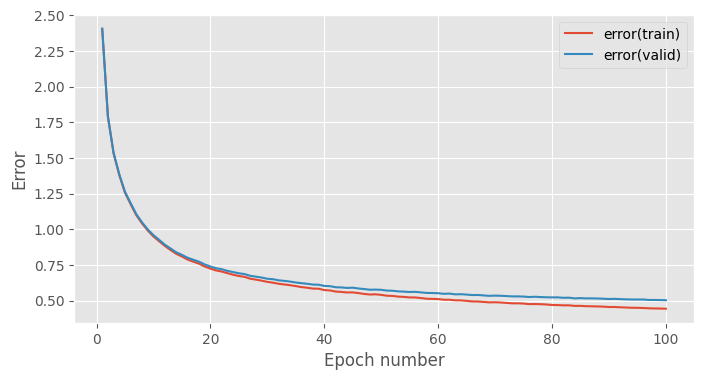

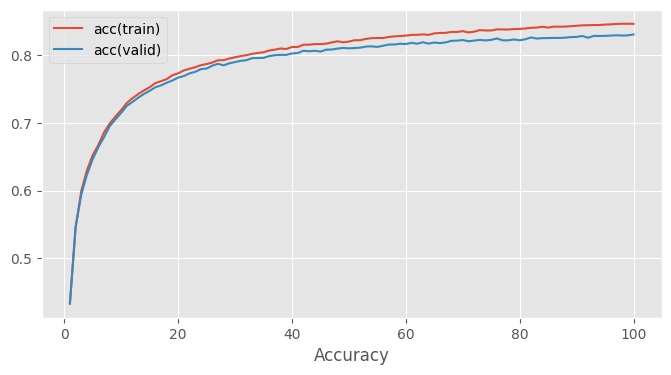

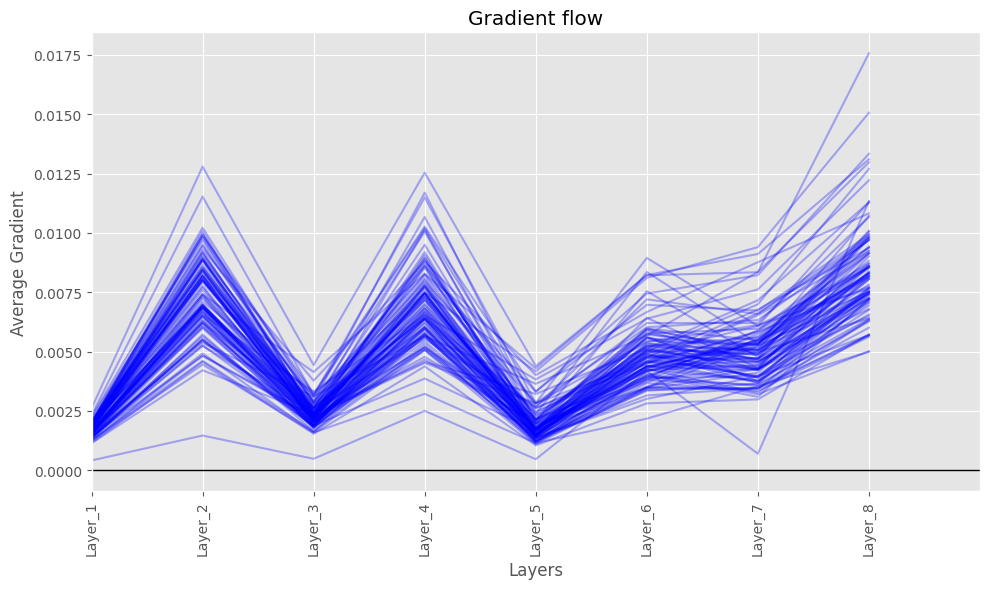

In [32]:
print("Training with Dropout (p=0.7)")
train_data.reset()
valid_data.reset()

layer1 = AffineLayer(input_dim, 128, weights_init, biases_init)
activation1 = ReluLayer()
dropout1 = DropoutLayer(rng=rng, incl_prob=0.7)

layer2 = AffineLayer(128, 128, weights_init, biases_init)
activation2 = ReluLayer()
dropout2 = DropoutLayer(rng=rng, incl_prob=0.7)

layer3 = AffineLayer(128, 128, weights_init, biases_init)
activation3 = ReluLayer()
dropout3 = DropoutLayer(rng=rng, incl_prob=0.7)

layer_out = AffineLayer(128, output_dim, weights_init, biases_init)

layers = [layer1, activation1, dropout1, layer2, activation2, dropout2, 
          layer3, activation3, dropout3, layer_out]
model = MultipleLayerModel(layers)

error = CrossEntropySoftmaxError()
learning_rule = AdamLearningRule(learning_rate=0.0001)

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, 100, 1, notebook=False)

dropout_07_stats = stats
dropout_07_keys = keys

print("Dropout 0.7 - Valid Error:", stats[-1, keys['error(valid)']])
print("Dropout 0.7 - Valid Acc:", stats[-1, keys['acc(valid)']])

Training with Dropout (p=0.9)


Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 214.35it/s]
Epoch 1: 4.7s to complete
    error(train)=1.60e+00, acc(train)=5.77e-01, error(valid)=1.59e+00, acc(valid)=5.79e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 196.36it/s]
Epoch 2: 5.1s to complete
    error(train)=1.27e+00, acc(train)=6.45e-01, error(valid)=1.27e+00, acc(valid)=6.42e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 224.51it/s]
Epoch 3: 4.5s to complete
    error(train)=1.11e+00, acc(train)=6.83e-01, error(valid)=1.11e+00, acc(valid)=6.79e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 226.71it/s]
Epoch 4: 4.4s to complete
    error(train)=9.94e-01, acc(train)=7.10e-01, error(valid)=1.00e+00, acc(valid)=7.08e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 242.66it/s]
Epoch 5: 4.1s to complete
    error(train)=9.12e-01, acc(train)=7.31e-01, error(valid)=9.21e-01, acc(valid)=7.26e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 235.46it/s]
Epoch 6: 4.3s to complete
    error(train)=

Dropout 0.9 - Valid Error: 0.4201026660186096
Dropout 0.9 - Valid Acc: 0.8562658227848101


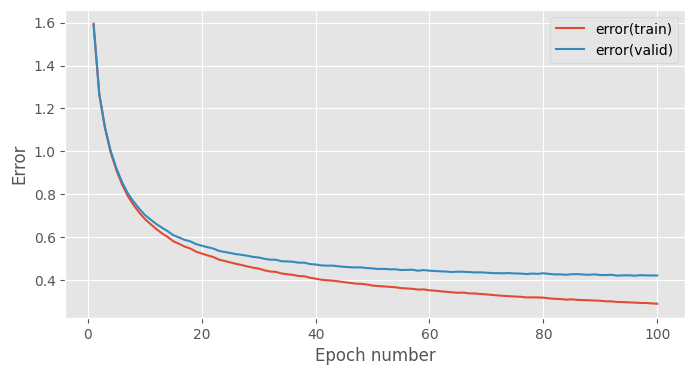

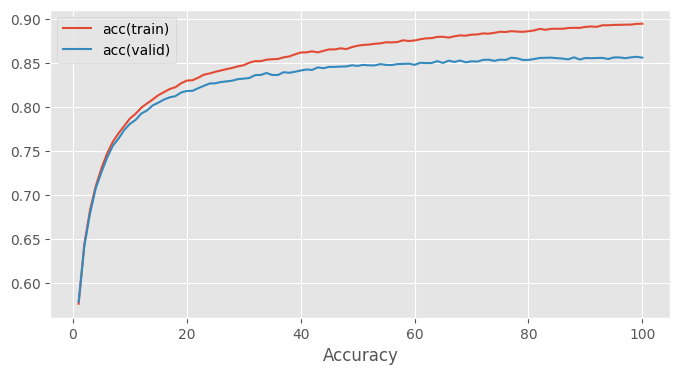

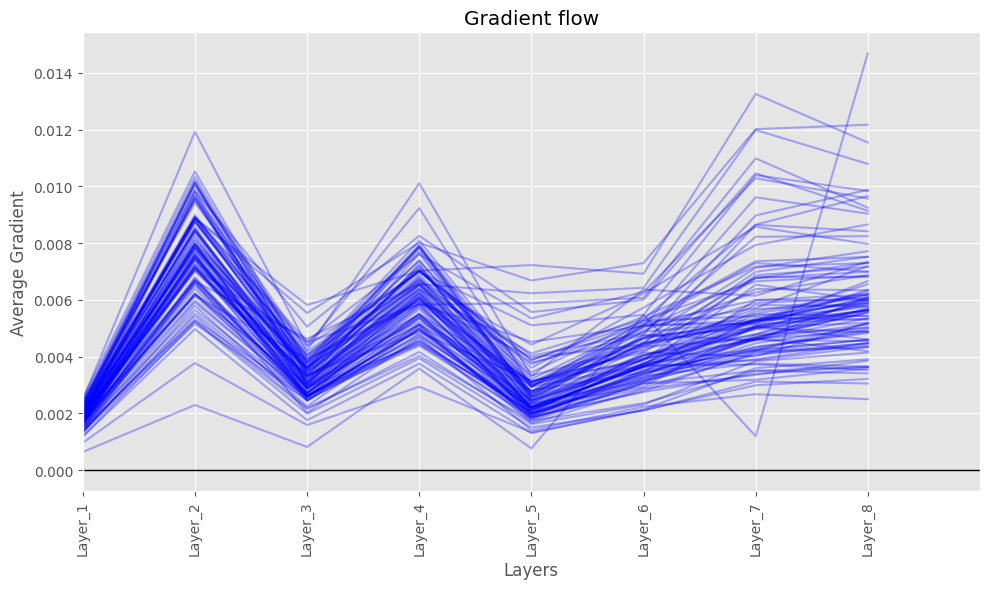

In [33]:
print("Training with Dropout (p=0.9)")
train_data.reset()
valid_data.reset()

layer1 = AffineLayer(input_dim, 128, weights_init, biases_init)
activation1 = ReluLayer()
dropout1 = DropoutLayer(rng=rng, incl_prob=0.9)

layer2 = AffineLayer(128, 128, weights_init, biases_init)
activation2 = ReluLayer()
dropout2 = DropoutLayer(rng=rng, incl_prob=0.9)

layer3 = AffineLayer(128, 128, weights_init, biases_init)
activation3 = ReluLayer()
dropout3 = DropoutLayer(rng=rng, incl_prob=0.9)

layer_out = AffineLayer(128, output_dim, weights_init, biases_init)

layers = [layer1, activation1, dropout1, layer2, activation2, dropout2, 
          layer3, activation3, dropout3, layer_out]
model = MultipleLayerModel(layers)

error = CrossEntropySoftmaxError()
learning_rule = AdamLearningRule(learning_rate=0.0001)

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, 100, 1, notebook=False)

dropout_09_stats = stats
dropout_09_keys = keys

print("Dropout 0.9 - Valid Error:", stats[-1, keys['error(valid)']])
print("Dropout 0.9 - Valid Acc:", stats[-1, keys['acc(valid)']])

Training with L1 Penalty (coefficient=0.0001)


Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 184.64it/s]
Epoch 1: 5.4s to complete
    error(train)=1.35e+00, acc(train)=6.25e-01, error(valid)=1.35e+00, acc(valid)=6.20e-01
Ep Prog: 100%|██████████| 1000/1000 [00:06<00:00, 158.36it/s]
Epoch 2: 6.3s to complete
    error(train)=1.13e+00, acc(train)=6.81e-01, error(valid)=1.13e+00, acc(valid)=6.75e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 199.69it/s]
Epoch 3: 5.0s to complete
    error(train)=1.01e+00, acc(train)=7.11e-01, error(valid)=1.02e+00, acc(valid)=7.04e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 190.39it/s]
Epoch 4: 5.3s to complete
    error(train)=9.28e-01, acc(train)=7.32e-01, error(valid)=9.38e-01, acc(valid)=7.27e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 180.44it/s]
Epoch 5: 5.6s to complete
    error(train)=8.65e-01, acc(train)=7.48e-01, error(valid)=8.79e-01, acc(valid)=7.40e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 176.86it/s]
Epoch 6: 5.7s to complete
    error(train)=

L1 0.0001 - Valid Error: 0.46065975567583134
L1 0.0001 - Valid Acc: 0.8506962025316457


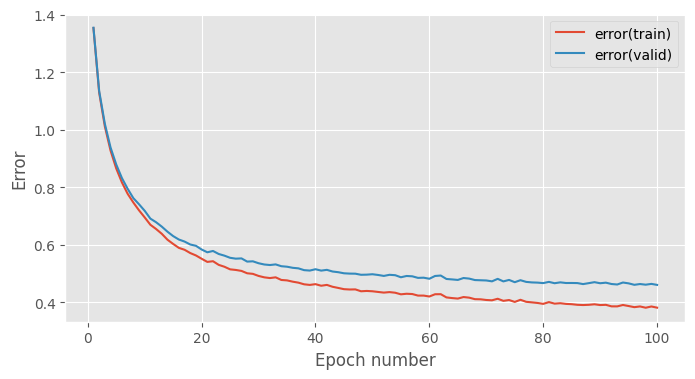

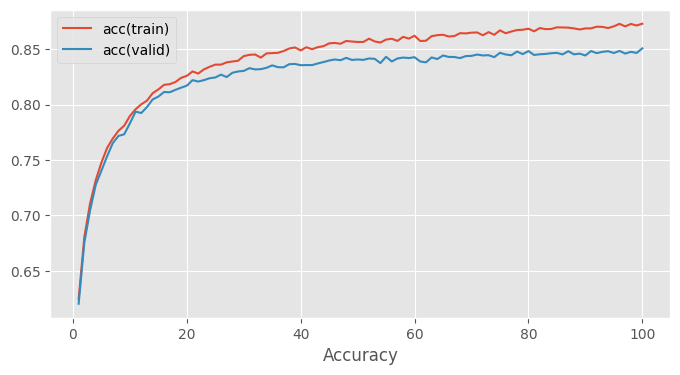

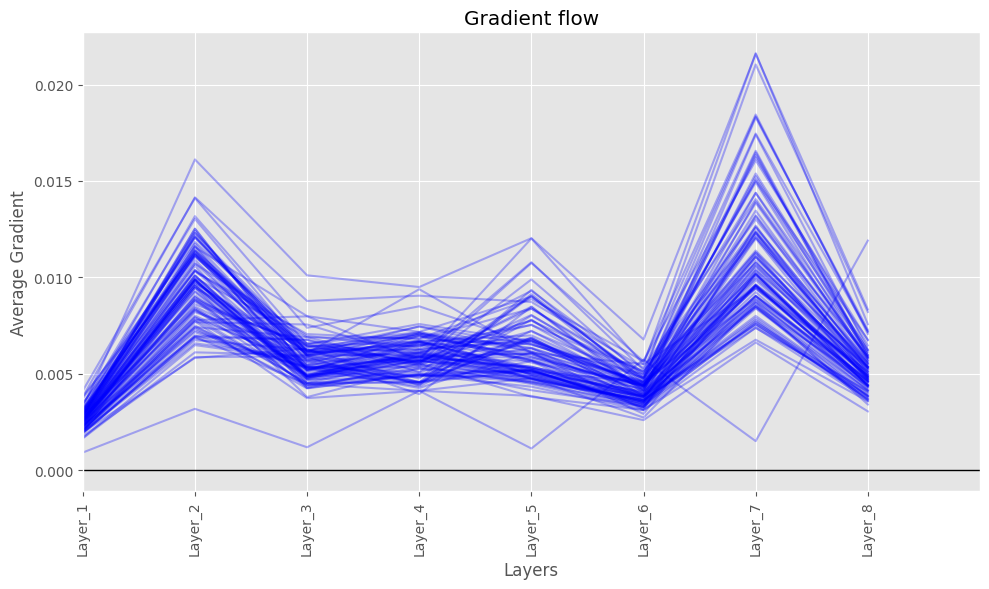

In [34]:
from mlp.penalties import L1Penalty

print("Training with L1 Penalty (coefficient=0.0001)")
train_data.reset()
valid_data.reset()

input_dim, output_dim, hidden_dim = 784, 47, 128

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

penalty = L1Penalty(coefficient=0.0001)

layer1 = AffineLayer(input_dim, 128, weights_init, biases_init, 
                     weights_penalty=penalty, biases_penalty=penalty)
activation1 = ReluLayer()

layer2 = AffineLayer(128, 128, weights_init, biases_init,
                     weights_penalty=penalty, biases_penalty=penalty)
activation2 = ReluLayer()

layer3 = AffineLayer(128, 128, weights_init, biases_init,
                     weights_penalty=penalty, biases_penalty=penalty)
activation3 = ReluLayer()

layer_out = AffineLayer(128, output_dim, weights_init, biases_init,
                        weights_penalty=penalty, biases_penalty=penalty)

layers = [layer1, activation1, layer2, activation2, layer3, activation3, layer_out]
model = MultipleLayerModel(layers)

error = CrossEntropySoftmaxError()
learning_rule = AdamLearningRule(learning_rate=0.0001)

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, 100, 1, notebook=False)

l1_0001_stats = stats
l1_0001_keys = keys

print("L1 0.0001 - Valid Error:", stats[-1, keys['error(valid)']])
print("L1 0.0001 - Valid Acc:", stats[-1, keys['acc(valid)']])

Training with L1 Penalty (coefficient=0.001)


Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 178.41it/s]
Epoch 1: 5.6s to complete
    error(train)=1.69e+00, acc(train)=5.56e-01, error(valid)=1.69e+00, acc(valid)=5.50e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 182.35it/s]
Epoch 2: 5.5s to complete
    error(train)=1.55e+00, acc(train)=5.89e-01, error(valid)=1.56e+00, acc(valid)=5.81e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 192.24it/s]
Epoch 3: 5.2s to complete
    error(train)=1.47e+00, acc(train)=6.08e-01, error(valid)=1.48e+00, acc(valid)=6.01e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 194.72it/s]
Epoch 4: 5.1s to complete
    error(train)=1.42e+00, acc(train)=6.19e-01, error(valid)=1.43e+00, acc(valid)=6.11e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 194.08it/s]
Epoch 5: 5.2s to complete
    error(train)=1.38e+00, acc(train)=6.27e-01, error(valid)=1.39e+00, acc(valid)=6.18e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 203.32it/s]
Epoch 6: 4.9s to complete
    error(train)=

L1 0.001 - Valid Error: 0.8879728213999855
L1 0.001 - Valid Acc: 0.7373417721518992


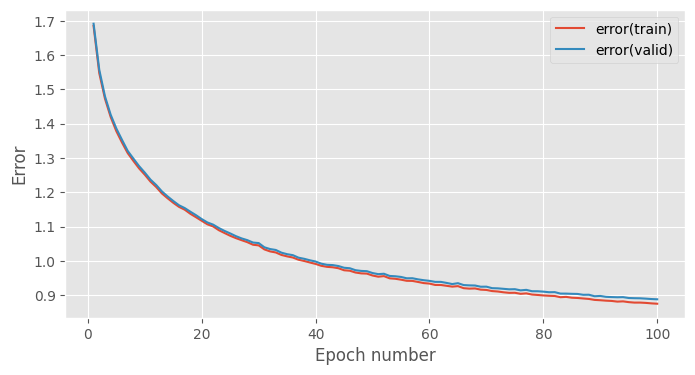

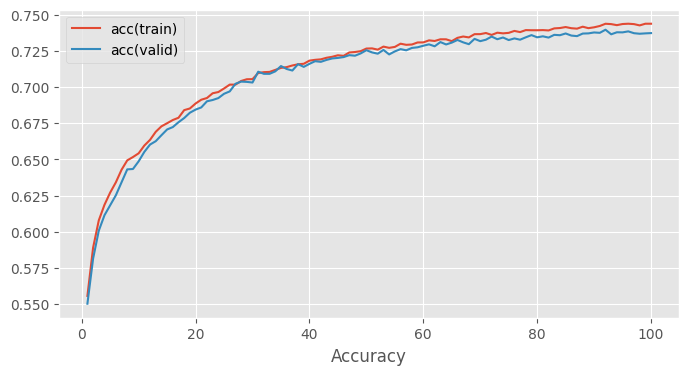

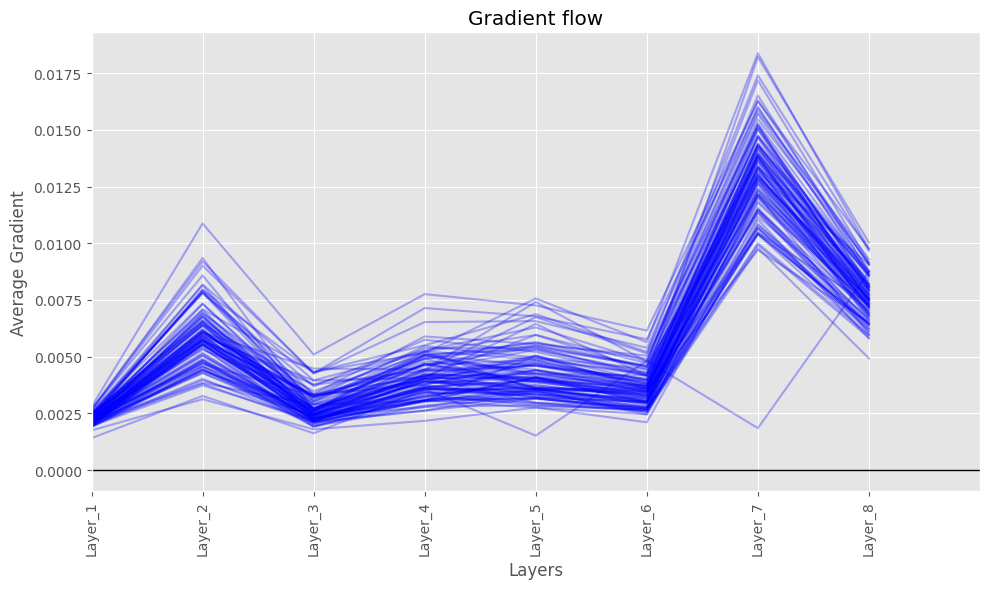

In [35]:
print("Training with L1 Penalty (coefficient=0.001)")
train_data.reset()
valid_data.reset()

penalty = L1Penalty(coefficient=0.001)

layer1 = AffineLayer(input_dim, 128, weights_init, biases_init, 
                     weights_penalty=penalty, biases_penalty=penalty)
activation1 = ReluLayer()

layer2 = AffineLayer(128, 128, weights_init, biases_init,
                     weights_penalty=penalty, biases_penalty=penalty)
activation2 = ReluLayer()

layer3 = AffineLayer(128, 128, weights_init, biases_init,
                     weights_penalty=penalty, biases_penalty=penalty)
activation3 = ReluLayer()

layer_out = AffineLayer(128, output_dim, weights_init, biases_init,
                        weights_penalty=penalty, biases_penalty=penalty)

layers = [layer1, activation1, layer2, activation2, layer3, activation3, layer_out]
model = MultipleLayerModel(layers)

error = CrossEntropySoftmaxError()
learning_rule = AdamLearningRule(learning_rate=0.0001)

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, 100, 1, notebook=False)

l1_001_stats = stats
l1_001_keys = keys

print("L1 0.001 - Valid Error:", stats[-1, keys['error(valid)']])
print("L1 0.001 - Valid Acc:", stats[-1, keys['acc(valid)']])

Training with L1 Penalty (coefficient=0.01)


Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 196.85it/s]
Epoch 1: 5.1s to complete
    error(train)=3.85e+00, acc(train)=2.13e-02, error(valid)=3.85e+00, acc(valid)=2.15e-02
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 190.16it/s]
Epoch 2: 5.3s to complete
    error(train)=3.85e+00, acc(train)=2.13e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 203.29it/s]
Epoch 3: 4.9s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.11e-02
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 215.33it/s]
Epoch 4: 4.7s to complete
    error(train)=3.85e+00, acc(train)=2.13e-02, error(valid)=3.85e+00, acc(valid)=2.21e-02
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 198.35it/s]
Epoch 5: 5.1s to complete
    error(train)=3.85e+00, acc(train)=2.12e-02, error(valid)=3.85e+00, acc(valid)=2.22e-02
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 208.71it/s]
Epoch 6: 4.8s to complete
    error(train)=

L1 0.01 - Valid Error: 3.850148044115014
L1 0.01 - Valid Acc: 0.02012658227848098


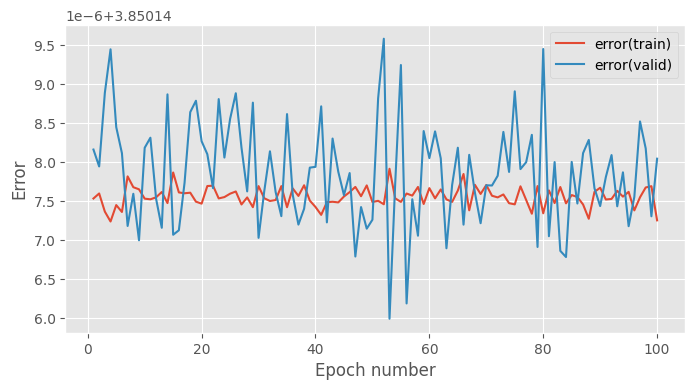

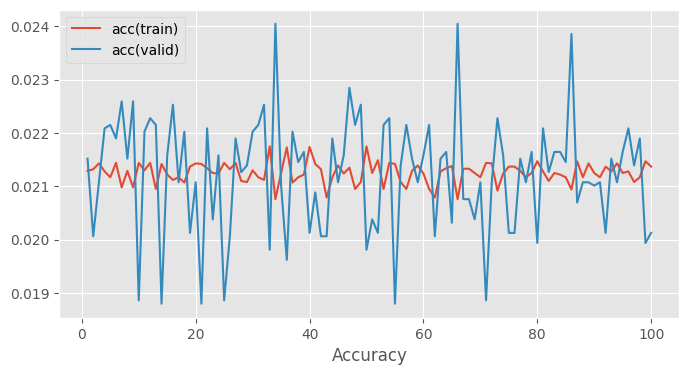

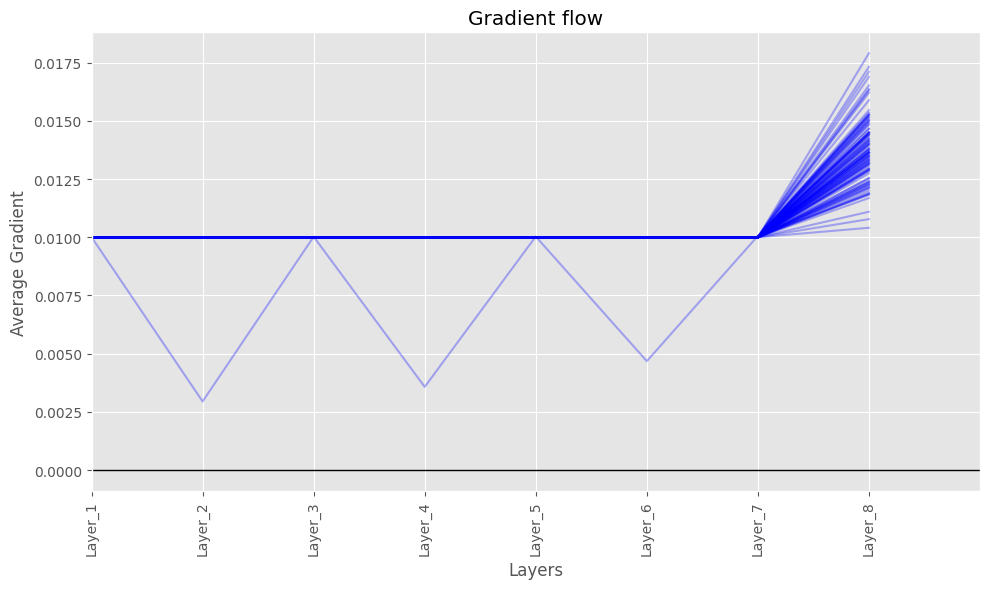

In [36]:
print("Training with L1 Penalty (coefficient=0.01)")
train_data.reset()
valid_data.reset()

penalty = L1Penalty(coefficient=0.01)

layer1 = AffineLayer(input_dim, 128, weights_init, biases_init, 
                     weights_penalty=penalty, biases_penalty=penalty)
activation1 = ReluLayer()

layer2 = AffineLayer(128, 128, weights_init, biases_init,
                     weights_penalty=penalty, biases_penalty=penalty)
activation2 = ReluLayer()

layer3 = AffineLayer(128, 128, weights_init, biases_init,
                     weights_penalty=penalty, biases_penalty=penalty)
activation3 = ReluLayer()

layer_out = AffineLayer(128, output_dim, weights_init, biases_init,
                        weights_penalty=penalty, biases_penalty=penalty)

layers = [layer1, activation1, layer2, activation2, layer3, activation3, layer_out]
model = MultipleLayerModel(layers)

error = CrossEntropySoftmaxError()
learning_rule = AdamLearningRule(learning_rate=0.0001)

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, 100, 1, notebook=False)

l1_01_stats = stats
l1_01_keys = keys

print("L1 0.01 - Valid Error:", stats[-1, keys['error(valid)']])
print("L1 0.01 - Valid Acc:", stats[-1, keys['acc(valid)']])

Training with L2 Penalty (coefficient=0.0001)


Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 275.74it/s]
Epoch 1: 3.6s to complete
    error(train)=1.34e+00, acc(train)=6.26e-01, error(valid)=1.34e+00, acc(valid)=6.17e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 307.41it/s]
Epoch 2: 3.3s to complete
    error(train)=1.13e+00, acc(train)=6.80e-01, error(valid)=1.14e+00, acc(valid)=6.72e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 288.11it/s]
Epoch 3: 3.5s to complete
    error(train)=9.93e-01, acc(train)=7.14e-01, error(valid)=1.01e+00, acc(valid)=7.07e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 325.74it/s]
Epoch 4: 3.1s to complete
    error(train)=9.00e-01, acc(train)=7.38e-01, error(valid)=9.18e-01, acc(valid)=7.31e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 311.90it/s]
Epoch 5: 3.2s to complete
    error(train)=8.30e-01, acc(train)=7.56e-01, error(valid)=8.50e-01, acc(valid)=7.48e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 284.91it/s]
Epoch 6: 3.5s to complete
    error(train)=

L2 0.0001 - Valid Error: 0.504355420568267
L2 0.0001 - Valid Acc: 0.841772151898734


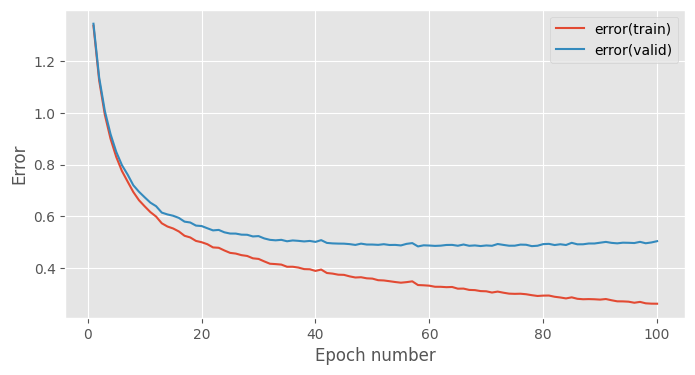

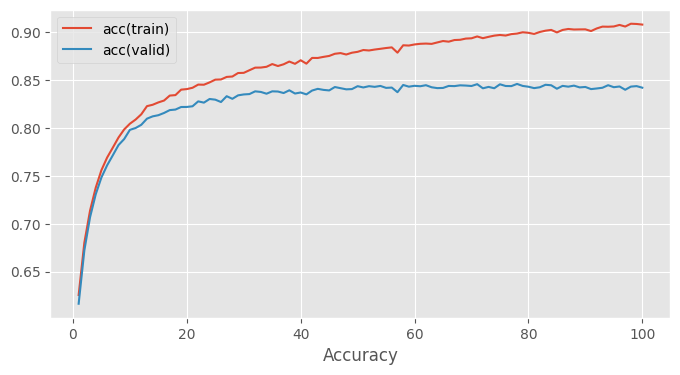

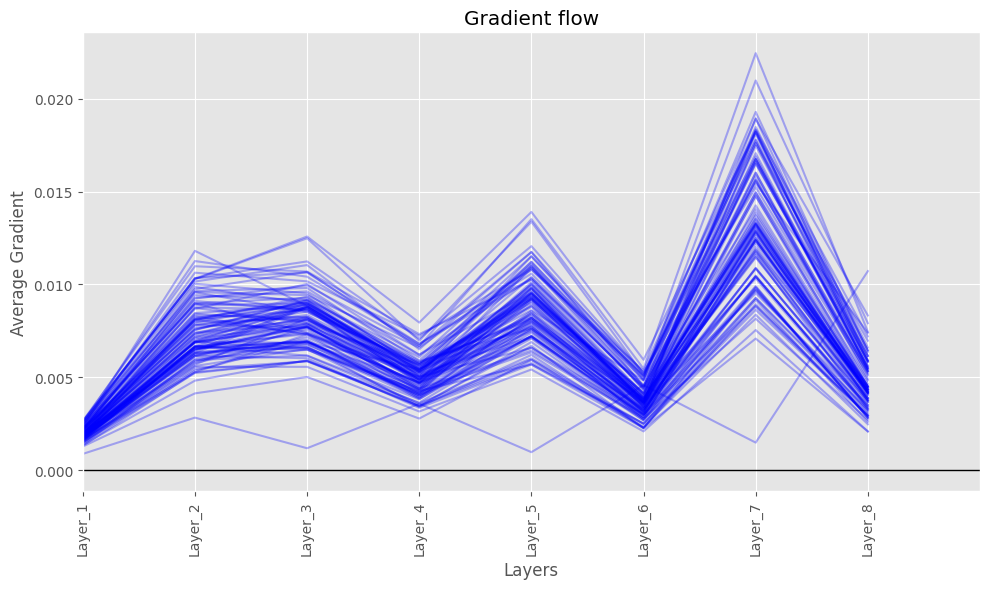

In [37]:
from mlp.penalties import L2Penalty

print("Training with L2 Penalty (coefficient=0.0001)")
train_data.reset()
valid_data.reset()

penalty = L2Penalty(coefficient=0.0001)

layer1 = AffineLayer(input_dim, 128, weights_init, biases_init, 
                     weights_penalty=penalty, biases_penalty=penalty)
activation1 = ReluLayer()

layer2 = AffineLayer(128, 128, weights_init, biases_init,
                     weights_penalty=penalty, biases_penalty=penalty)
activation2 = ReluLayer()

layer3 = AffineLayer(128, 128, weights_init, biases_init,
                     weights_penalty=penalty, biases_penalty=penalty)
activation3 = ReluLayer()

layer_out = AffineLayer(128, output_dim, weights_init, biases_init,
                        weights_penalty=penalty, biases_penalty=penalty)

layers = [layer1, activation1, layer2, activation2, layer3, activation3, layer_out]
model = MultipleLayerModel(layers)

error = CrossEntropySoftmaxError()
learning_rule = AdamLearningRule(learning_rate=0.0001)

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, 100, 1, notebook=False)

l2_0001_stats = stats
l2_0001_keys = keys

print("L2 0.0001 - Valid Error:", stats[-1, keys['error(valid)']])
print("L2 0.0001 - Valid Acc:", stats[-1, keys['acc(valid)']])

Training with L2 Penalty (coefficient=0.001)


Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 251.62it/s]
Epoch 1: 4.0s to complete
    error(train)=1.36e+00, acc(train)=6.26e-01, error(valid)=1.35e+00, acc(valid)=6.23e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 289.23it/s]
Epoch 2: 3.5s to complete
    error(train)=1.13e+00, acc(train)=6.79e-01, error(valid)=1.13e+00, acc(valid)=6.76e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 265.58it/s]
Epoch 3: 3.8s to complete
    error(train)=9.94e-01, acc(train)=7.17e-01, error(valid)=9.99e-01, acc(valid)=7.17e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 305.78it/s]
Epoch 4: 3.3s to complete
    error(train)=9.09e-01, acc(train)=7.36e-01, error(valid)=9.17e-01, acc(valid)=7.32e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 282.48it/s]
Epoch 5: 3.5s to complete
    error(train)=8.37e-01, acc(train)=7.56e-01, error(valid)=8.49e-01, acc(valid)=7.51e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 285.98it/s]
Epoch 6: 3.5s to complete
    error(train)=

L2 0.001 - Valid Error: 0.46045494827852146
L2 0.001 - Valid Acc: 0.8478481012658227


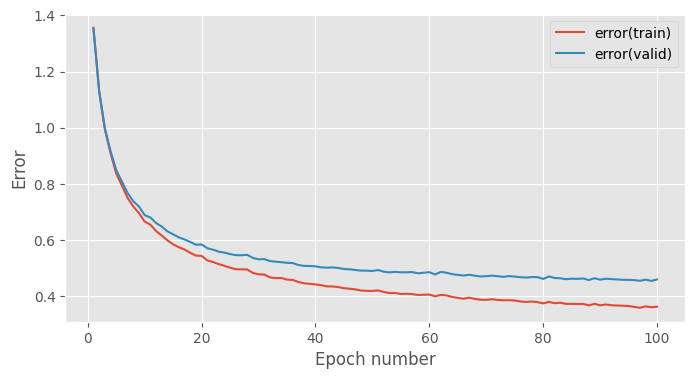

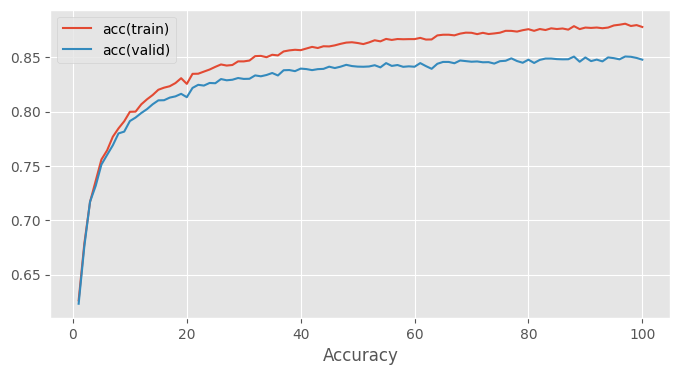

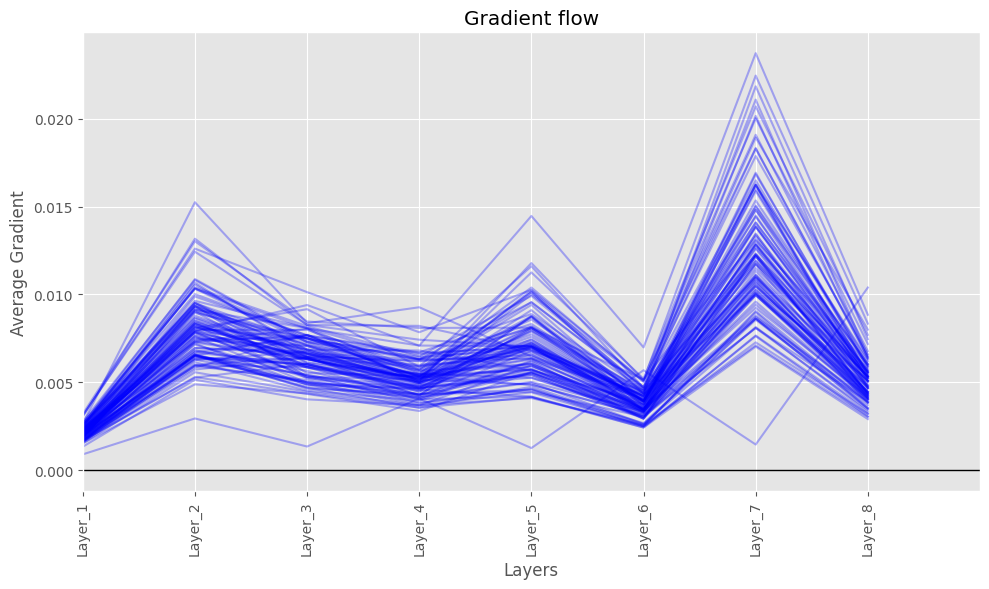

In [38]:
# L2 with coefficient 0.001
print("Training with L2 Penalty (coefficient=0.001)")
train_data.reset()
valid_data.reset()

penalty = L2Penalty(coefficient=0.001)

layer1 = AffineLayer(input_dim, 128, weights_init, biases_init, 
                     weights_penalty=penalty, biases_penalty=penalty)
activation1 = ReluLayer()

layer2 = AffineLayer(128, 128, weights_init, biases_init,
                     weights_penalty=penalty, biases_penalty=penalty)
activation2 = ReluLayer()

layer3 = AffineLayer(128, 128, weights_init, biases_init,
                     weights_penalty=penalty, biases_penalty=penalty)
activation3 = ReluLayer()

layer_out = AffineLayer(128, output_dim, weights_init, biases_init,
                        weights_penalty=penalty, biases_penalty=penalty)

layers = [layer1, activation1, layer2, activation2, layer3, activation3, layer_out]
model = MultipleLayerModel(layers)

error = CrossEntropySoftmaxError()
learning_rule = AdamLearningRule(learning_rate=1e-4)

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, 100, 1, notebook=False)

l2_001_stats = stats
l2_001_keys = keys

print("L2 0.001 - Valid Error:", stats[-1, keys['error(valid)']])
print("L2 0.001 - Valid Acc:", stats[-1, keys['acc(valid)']])

Training with L2 Penalty (coefficient=0.01)


Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 274.54it/s]
Epoch 1: 3.7s to complete
    error(train)=1.55e+00, acc(train)=5.83e-01, error(valid)=1.56e+00, acc(valid)=5.80e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 277.16it/s]
Epoch 2: 3.6s to complete
    error(train)=1.34e+00, acc(train)=6.35e-01, error(valid)=1.34e+00, acc(valid)=6.31e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 320.45it/s]
Epoch 3: 3.1s to complete
    error(train)=1.23e+00, acc(train)=6.62e-01, error(valid)=1.24e+00, acc(valid)=6.58e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 286.94it/s]
Epoch 4: 3.5s to complete
    error(train)=1.17e+00, acc(train)=6.79e-01, error(valid)=1.17e+00, acc(valid)=6.75e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 280.59it/s]
Epoch 5: 3.6s to complete
    error(train)=1.11e+00, acc(train)=6.93e-01, error(valid)=1.12e+00, acc(valid)=6.89e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 297.29it/s]
Epoch 6: 3.4s to complete
    error(train)=

L2 0.01 - Valid Error: 0.7831439470664825
L2 0.01 - Valid Acc: 0.7774683544303799


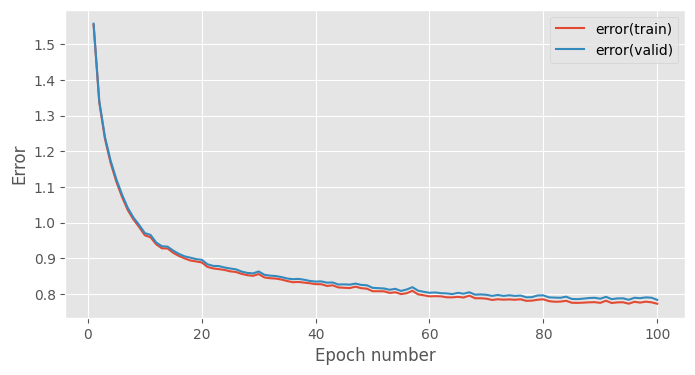

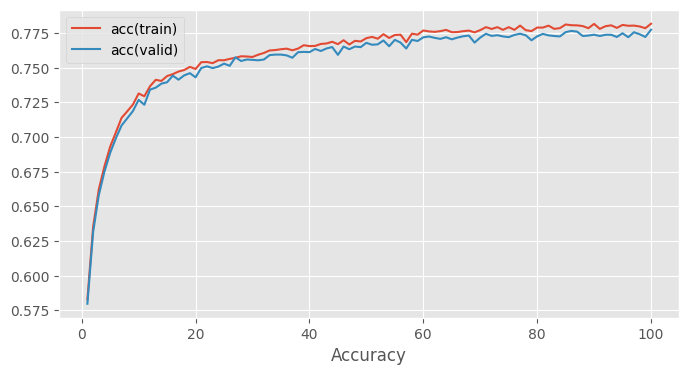

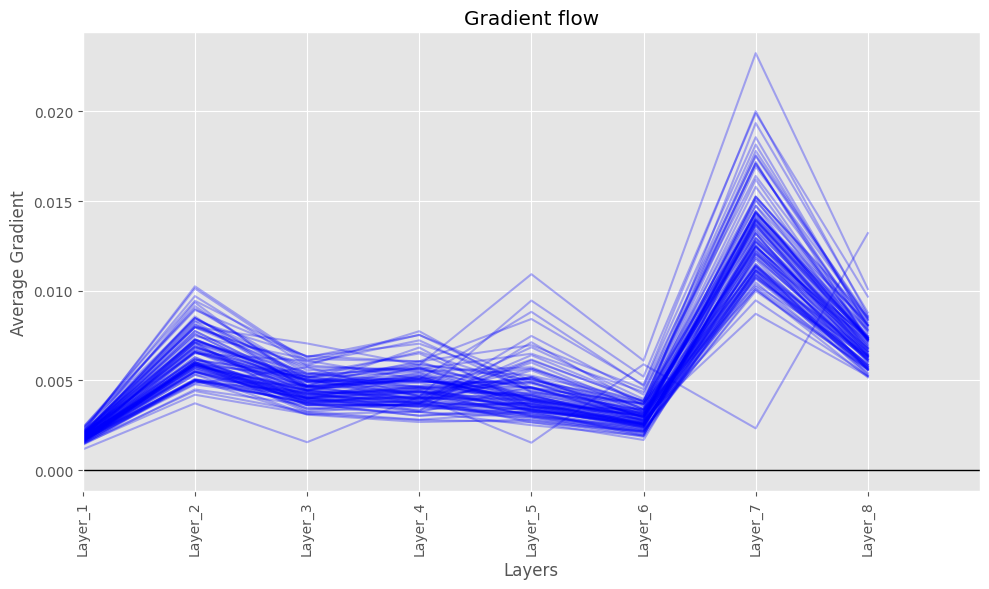

In [39]:
# L2 with coefficient 0.01
print("Training with L2 Penalty (coefficient=0.01)")
train_data.reset()
valid_data.reset()

penalty = L2Penalty(coefficient=0.01)

layer1 = AffineLayer(input_dim, 128, weights_init, biases_init, 
                     weights_penalty=penalty, biases_penalty=penalty)
activation1 = ReluLayer()

layer2 = AffineLayer(128, 128, weights_init, biases_init,
                     weights_penalty=penalty, biases_penalty=penalty)
activation2 = ReluLayer()

layer3 = AffineLayer(128, 128, weights_init, biases_init,
                     weights_penalty=penalty, biases_penalty=penalty)
activation3 = ReluLayer()

layer_out = AffineLayer(128, output_dim, weights_init, biases_init,
                        weights_penalty=penalty, biases_penalty=penalty)

layers = [layer1, activation1, layer2, activation2, layer3, activation3, layer_out]
model = MultipleLayerModel(layers)

error = CrossEntropySoftmaxError()
learning_rule = AdamLearningRule(learning_rate=1e-4)

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, 100, 1, notebook=False)

l2_01_stats = stats
l2_01_keys = keys

print("L2 0.01 - Valid Error:", stats[-1, keys['error(valid)']])
print("L2 0.01 - Valid Acc:", stats[-1, keys['acc(valid)']])

KeysView(NpzFile 'd:\\MSc\\MLP\\mlpractical\\mlpractical/data\\emnist-train.npz' with keys: inputs, targets)
KeysView(NpzFile 'd:\\MSc\\MLP\\mlpractical\\mlpractical/data\\emnist-valid.npz' with keys: inputs, targets)
Training with Label Smoothing


Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 249.88it/s]
Epoch 1: 4.0s to complete
    error(train)=1.90e+00, acc(train)=6.33e-01, error(valid)=1.91e+00, acc(valid)=6.28e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 182.27it/s]
Epoch 2: 5.5s to complete
    error(train)=1.72e+00, acc(train)=6.93e-01, error(valid)=1.73e+00, acc(valid)=6.90e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 210.52it/s]
Epoch 3: 4.8s to complete
    error(train)=1.62e+00, acc(train)=7.24e-01, error(valid)=1.63e+00, acc(valid)=7.17e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 209.34it/s]
Epoch 4: 4.8s to complete
    error(train)=1.54e+00, acc(train)=7.50e-01, error(valid)=1.56e+00, acc(valid)=7.42e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 224.06it/s]
Epoch 5: 4.5s to complete
    error(train)=1.49e+00, acc(train)=7.66e-01, error(valid)=1.51e+00, acc(valid)=7.58e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 206.08it/s]
Epoch 6: 4.9s to complete
    error(train)=

Label Smoothing - Valid Error: 1.169558474537231
Label Smoothing - Valid Acc: 0.8443670886075949


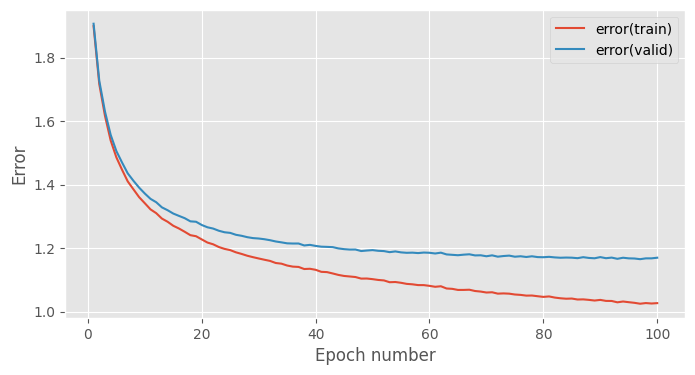

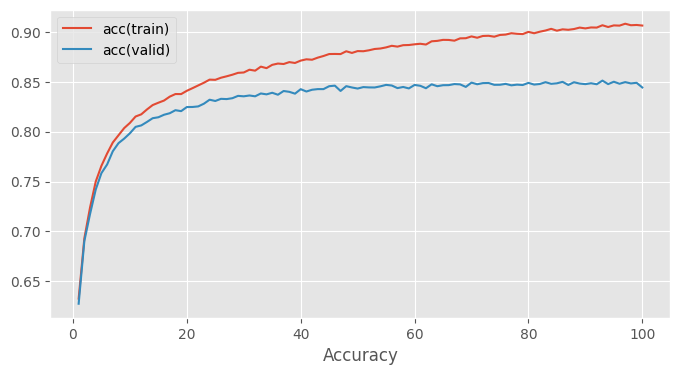

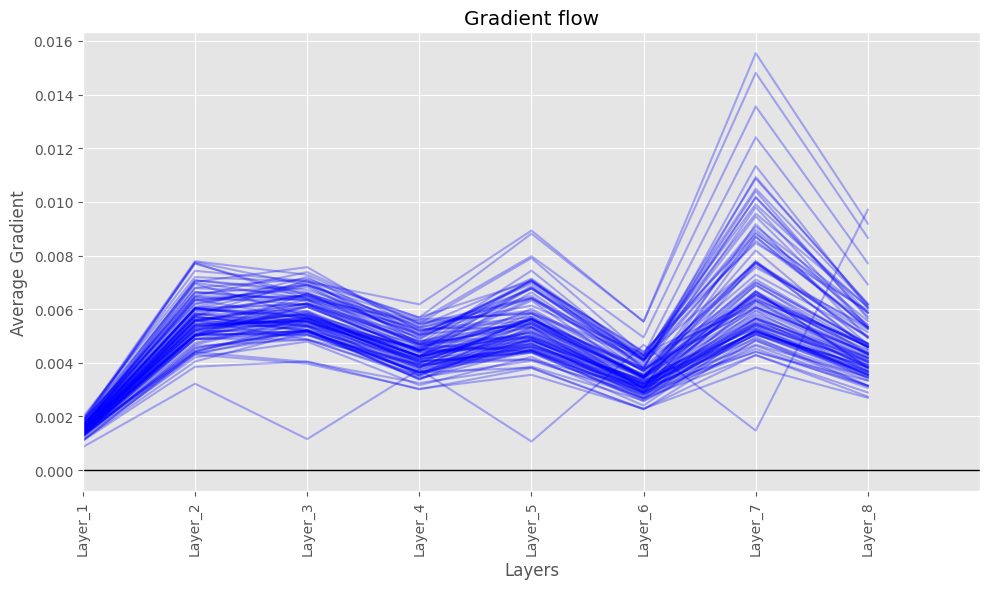

In [40]:
train_data_smooth = EMNISTDataProvider('train', batch_size=batch_size, rng=rng, smooth_labels=True)
valid_data_smooth = EMNISTDataProvider('valid', batch_size=batch_size, rng=rng, smooth_labels=True)

print("Training with Label Smoothing")

input_dim, output_dim, hidden_dim = 784, 47, 128

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

layer1 = AffineLayer(input_dim, 128, weights_init, biases_init)
activation1 = ReluLayer()
layer2 = AffineLayer(128, 128, weights_init, biases_init)
activation2 = ReluLayer()
layer3 = AffineLayer(128, 128, weights_init, biases_init)
activation3 = ReluLayer()
layer_out = AffineLayer(128, output_dim, weights_init, biases_init)

layers = [layer1, activation1, layer2, activation2, layer3, activation3, layer_out]
model = MultipleLayerModel(layers)

error = CrossEntropySoftmaxError()
learning_rule = AdamLearningRule(learning_rate=0.0001)

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data_smooth, valid_data_smooth, 100, 1, notebook=False)

ls_stats = stats
ls_keys = keys

print("Label Smoothing - Valid Error:", stats[-1, keys['error(valid)']])
print("Label Smoothing - Valid Acc:", stats[-1, keys['acc(valid)']])

Training with L1L2Mix - Balanced


Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 212.11it/s]
Epoch 1: 4.7s to complete
    error(train)=1.50e+00, acc(train)=5.94e-01, error(valid)=1.50e+00, acc(valid)=5.94e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 220.66it/s]
Epoch 2: 4.5s to complete
    error(train)=1.33e+00, acc(train)=6.35e-01, error(valid)=1.33e+00, acc(valid)=6.31e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 230.66it/s]
Epoch 3: 4.3s to complete
    error(train)=1.26e+00, acc(train)=6.54e-01, error(valid)=1.27e+00, acc(valid)=6.50e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 232.27it/s]
Epoch 4: 4.3s to complete
    error(train)=1.19e+00, acc(train)=6.71e-01, error(valid)=1.20e+00, acc(valid)=6.69e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 244.23it/s]
Epoch 5: 4.1s to complete
    error(train)=1.14e+00, acc(train)=6.83e-01, error(valid)=1.15e+00, acc(valid)=6.82e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 229.71it/s]
Epoch 6: 4.4s to complete
    error(train)=

L1L2 Balanced - Valid Error: 0.706341575107847
L1L2 Balanced - Valid Acc: 0.7877215189873416


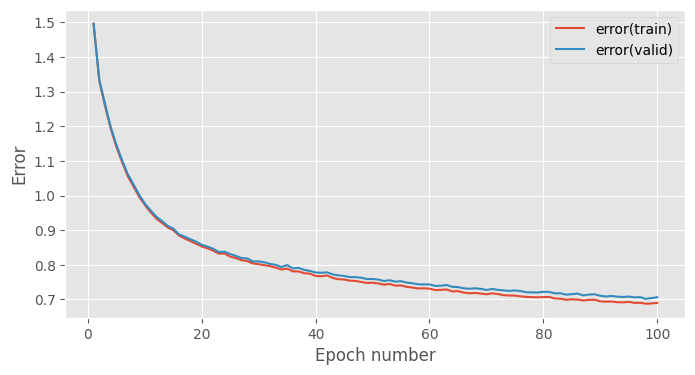

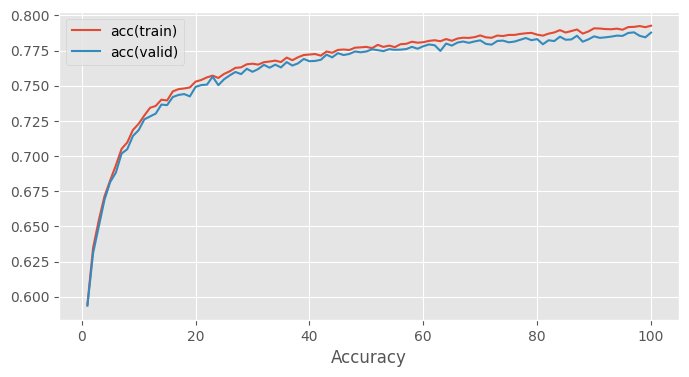

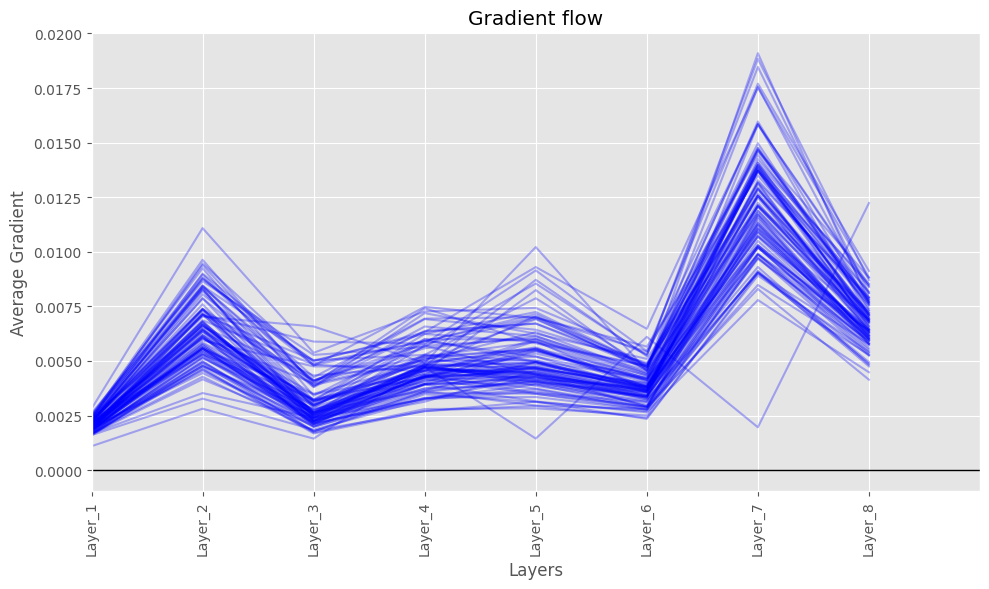

In [41]:
from mlp.penalties import L1L2MixPenalty

print("Training with L1L2Mix - Balanced")
train_data.reset()
valid_data.reset()

penalty = L1L2MixPenalty(l1_coefficient=0.0005, l2_coefficient=0.0005)

layer1 = AffineLayer(input_dim, 128, weights_init, biases_init, 
                     weights_penalty=penalty, biases_penalty=penalty)
activation1 = ReluLayer()

layer2 = AffineLayer(128, 128, weights_init, biases_init,
                     weights_penalty=penalty, biases_penalty=penalty)
activation2 = ReluLayer()

layer3 = AffineLayer(128, 128, weights_init, biases_init,
                     weights_penalty=penalty, biases_penalty=penalty)
activation3 = ReluLayer()

layer_out = AffineLayer(128, output_dim, weights_init, biases_init,
                        weights_penalty=penalty, biases_penalty=penalty)

layers = [layer1, activation1, layer2, activation2, layer3, activation3, layer_out]
model = MultipleLayerModel(layers)

error = CrossEntropySoftmaxError()
learning_rule = AdamLearningRule(learning_rate=0.0001)

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, 100, 1, notebook=False)

l1l2_balanced_stats = stats
l1l2_balanced_keys = keys

print("L1L2 Balanced - Valid Error:", stats[-1, keys['error(valid)']])
print("L1L2 Balanced - Valid Acc:", stats[-1, keys['acc(valid)']])

Training with L1L2Mix - L1-heavy


Ep Prog: 100%|██████████| 1000/1000 [00:06<00:00, 162.13it/s]
Epoch 1: 6.2s to complete
    error(train)=1.66e+00, acc(train)=5.62e-01, error(valid)=1.66e+00, acc(valid)=5.59e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 168.49it/s]
Epoch 2: 5.9s to complete
    error(train)=1.53e+00, acc(train)=5.94e-01, error(valid)=1.53e+00, acc(valid)=5.90e-01
Ep Prog: 100%|██████████| 1000/1000 [00:06<00:00, 162.20it/s]
Epoch 3: 6.2s to complete
    error(train)=1.46e+00, acc(train)=6.08e-01, error(valid)=1.47e+00, acc(valid)=6.04e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 229.97it/s]
Epoch 4: 4.4s to complete
    error(train)=1.42e+00, acc(train)=6.16e-01, error(valid)=1.42e+00, acc(valid)=6.11e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 228.54it/s]
Epoch 5: 4.4s to complete
    error(train)=1.38e+00, acc(train)=6.27e-01, error(valid)=1.39e+00, acc(valid)=6.22e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 254.25it/s]
Epoch 6: 3.9s to complete
    error(train)=

L1L2 L1-heavy - Valid Error: 0.8678109367622328
L1L2 L1-heavy - Valid Acc: 0.7456329113924052


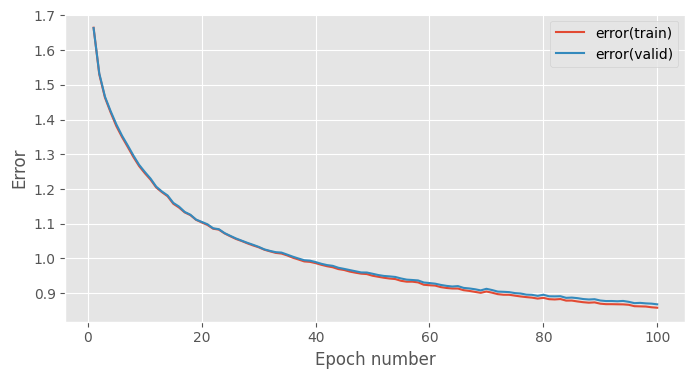

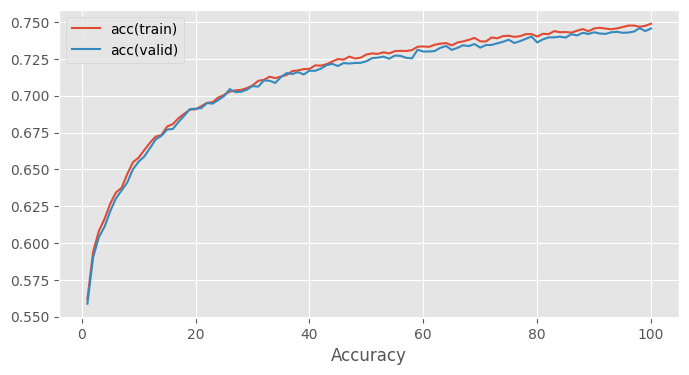

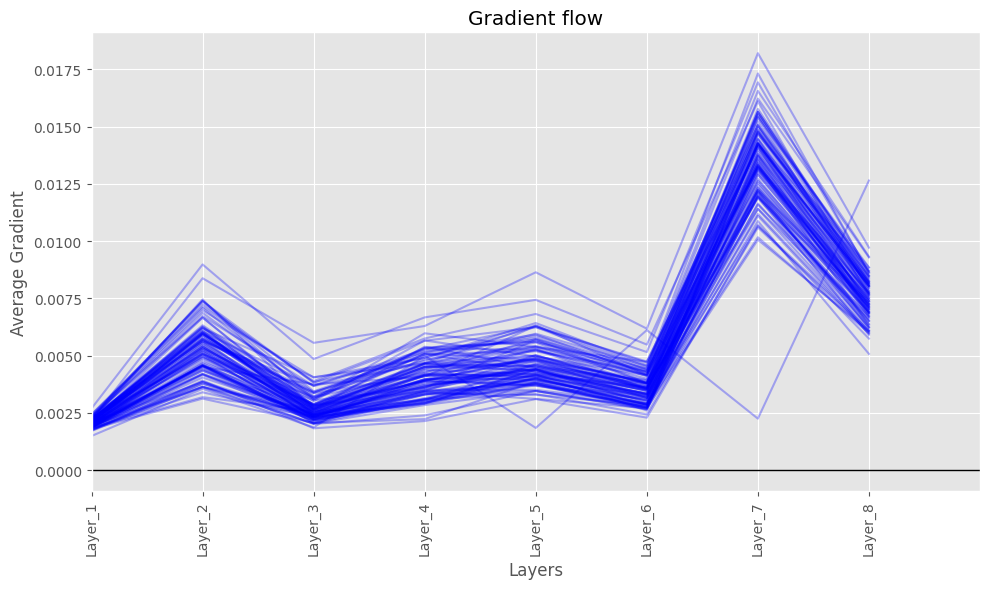

In [42]:
print("Training with L1L2Mix - L1-heavy")
train_data.reset()
valid_data.reset()

penalty = L1L2MixPenalty(l1_coefficient=0.001, l2_coefficient=0.0001)

layer1 = AffineLayer(input_dim, 128, weights_init, biases_init, 
                     weights_penalty=penalty, biases_penalty=penalty)
activation1 = ReluLayer()

layer2 = AffineLayer(128, 128, weights_init, biases_init,
                     weights_penalty=penalty, biases_penalty=penalty)
activation2 = ReluLayer()

layer3 = AffineLayer(128, 128, weights_init, biases_init,
                     weights_penalty=penalty, biases_penalty=penalty)
activation3 = ReluLayer()

layer_out = AffineLayer(128, output_dim, weights_init, biases_init,
                        weights_penalty=penalty, biases_penalty=penalty)

layers = [layer1, activation1, layer2, activation2, layer3, activation3, layer_out]
model = MultipleLayerModel(layers)

error = CrossEntropySoftmaxError()
learning_rule = AdamLearningRule(learning_rate=0.0001)

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, 100, 1, notebook=False)

l1l2_l1heavy_stats = stats
l1l2_l1heavy_keys = keys

print("L1L2 L1-heavy - Valid Error:", stats[-1, keys['error(valid)']])
print("L1L2 L1-heavy - Valid Acc:", stats[-1, keys['acc(valid)']])

Training with L1L2Mix - L2-heavy


Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 185.98it/s]
Epoch 1: 5.4s to complete
    error(train)=1.37e+00, acc(train)=6.23e-01, error(valid)=1.37e+00, acc(valid)=6.23e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 167.06it/s]
Epoch 2: 6.0s to complete
    error(train)=1.15e+00, acc(train)=6.78e-01, error(valid)=1.16e+00, acc(valid)=6.74e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 173.25it/s]
Epoch 3: 5.8s to complete
    error(train)=1.04e+00, acc(train)=7.05e-01, error(valid)=1.05e+00, acc(valid)=7.00e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 193.05it/s]
Epoch 4: 5.2s to complete
    error(train)=9.48e-01, acc(train)=7.28e-01, error(valid)=9.58e-01, acc(valid)=7.27e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 192.58it/s]
Epoch 5: 5.2s to complete
    error(train)=8.79e-01, acc(train)=7.47e-01, error(valid)=8.93e-01, acc(valid)=7.43e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 190.75it/s]
Epoch 6: 5.3s to complete
    error(train)=

L1L2 L2-heavy - Valid Error: 0.4976104092371531
L1L2 L2-heavy - Valid Acc: 0.8405063291139238


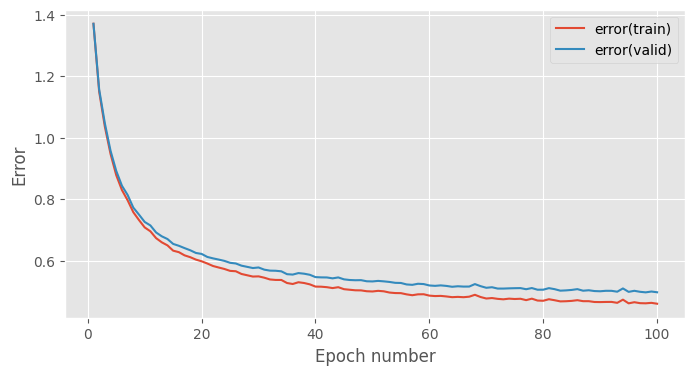

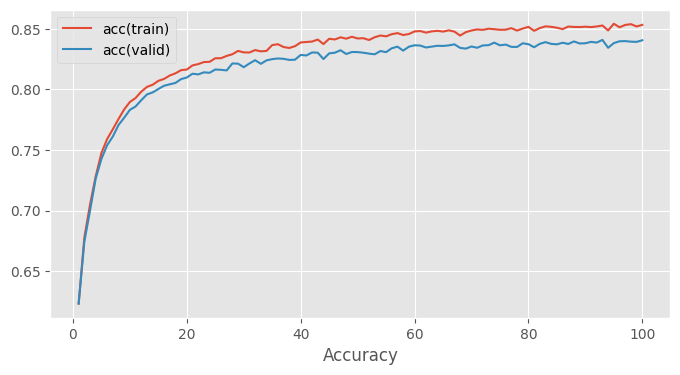

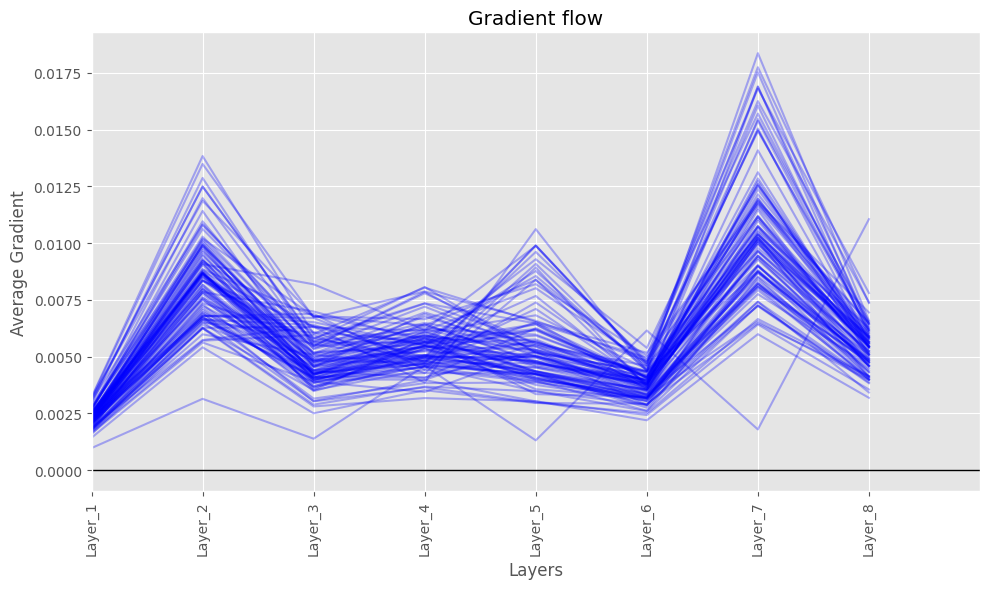

In [43]:
print("Training with L1L2Mix - L2-heavy")
train_data.reset()
valid_data.reset()

penalty = L1L2MixPenalty(l1_coefficient=0.0001, l2_coefficient=0.001)

layer1 = AffineLayer(input_dim, 128, weights_init, biases_init, 
                     weights_penalty=penalty, biases_penalty=penalty)
activation1 = ReluLayer()

layer2 = AffineLayer(128, 128, weights_init, biases_init,
                     weights_penalty=penalty, biases_penalty=penalty)
activation2 = ReluLayer()

layer3 = AffineLayer(128, 128, weights_init, biases_init,
                     weights_penalty=penalty, biases_penalty=penalty)
activation3 = ReluLayer()

layer_out = AffineLayer(128, output_dim, weights_init, biases_init,
                        weights_penalty=penalty, biases_penalty=penalty)

layers = [layer1, activation1, layer2, activation2, layer3, activation3, layer_out]
model = MultipleLayerModel(layers)

error = CrossEntropySoftmaxError()
learning_rule = AdamLearningRule(learning_rate=0.0001)

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, 100, 1, notebook=False)

l1l2_l2heavy_stats = stats
l1l2_l2heavy_keys = keys

print("L1L2 L2-heavy - Valid Error:", stats[-1, keys['error(valid)']])
print("L1L2 L2-heavy - Valid Acc:", stats[-1, keys['acc(valid)']])

Training with L1L2Mix - Mixed moderate


Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 197.71it/s]
Epoch 1: 5.1s to complete
    error(train)=1.45e+00, acc(train)=6.06e-01, error(valid)=1.44e+00, acc(valid)=6.04e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 186.65it/s]
Epoch 2: 5.4s to complete
    error(train)=1.23e+00, acc(train)=6.57e-01, error(valid)=1.24e+00, acc(valid)=6.56e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 211.62it/s]
Epoch 3: 4.7s to complete
    error(train)=1.13e+00, acc(train)=6.84e-01, error(valid)=1.13e+00, acc(valid)=6.79e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 205.31it/s]
Epoch 4: 4.9s to complete
    error(train)=1.07e+00, acc(train)=6.98e-01, error(valid)=1.07e+00, acc(valid)=6.91e-01
Ep Prog: 100%|██████████| 1000/1000 [00:05<00:00, 197.63it/s]
Epoch 5: 5.1s to complete
    error(train)=1.01e+00, acc(train)=7.11e-01, error(valid)=1.02e+00, acc(valid)=7.05e-01
Ep Prog: 100%|██████████| 1000/1000 [00:06<00:00, 161.76it/s]
Epoch 6: 6.2s to complete
    error(train)=

L1L2 Mixed - Valid Error: 0.5871837186729475
L1L2 Mixed - Valid Acc: 0.8163291139240506


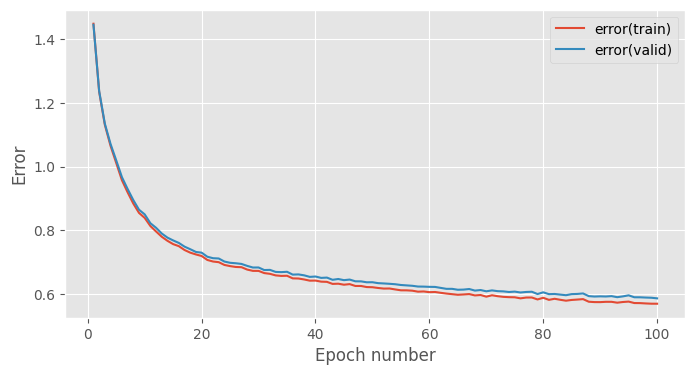

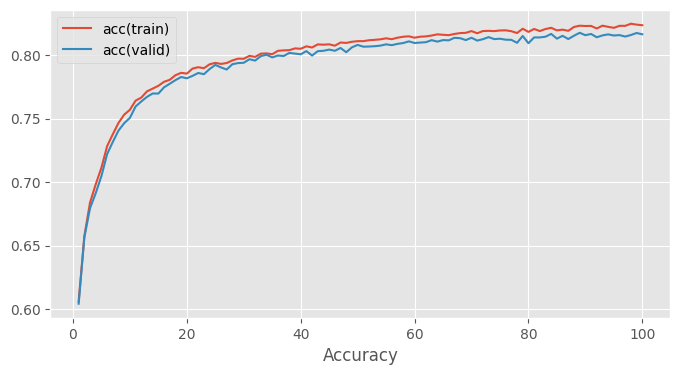

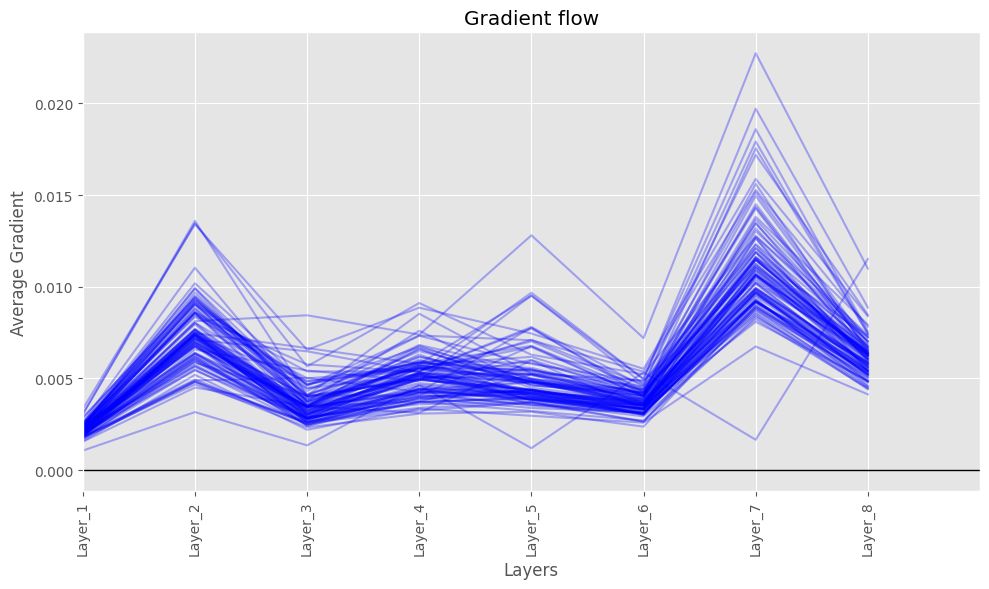

In [44]:
print("Training with L1L2Mix - Mixed moderate")
train_data.reset()
valid_data.reset()

penalty = L1L2MixPenalty(l1_coefficient=0.0003, l2_coefficient=0.0007)

layer1 = AffineLayer(input_dim, 128, weights_init, biases_init, 
                     weights_penalty=penalty, biases_penalty=penalty)
activation1 = ReluLayer()

layer2 = AffineLayer(128, 128, weights_init, biases_init,
                     weights_penalty=penalty, biases_penalty=penalty)
activation2 = ReluLayer()

layer3 = AffineLayer(128, 128, weights_init, biases_init,
                     weights_penalty=penalty, biases_penalty=penalty)
activation3 = ReluLayer()

layer_out = AffineLayer(128, output_dim, weights_init, biases_init,
                        weights_penalty=penalty, biases_penalty=penalty)

layers = [layer1, activation1, layer2, activation2, layer3, activation3, layer_out]
model = MultipleLayerModel(layers)

error = CrossEntropySoftmaxError()
learning_rule = AdamLearningRule(learning_rate=0.0001)

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, 100, 1, notebook=False)

l1l2_mixed_stats = stats
l1l2_mixed_keys = keys

print("L1L2 Mixed - Valid Error:", stats[-1, keys['error(valid)']])
print("L1L2 Mixed - Valid Acc:", stats[-1, keys['acc(valid)']])

In [45]:
print("TABLE 3: REGULARIZATION EXPERIMENTS (Missing values only)")

print("\nDropout 0.7:")
val_acc = dropout_07_stats[-1, dropout_07_keys['acc(valid)']] * 100
train_err = dropout_07_stats[-1, dropout_07_keys['error(train)']]
val_err = dropout_07_stats[-1, dropout_07_keys['error(valid)']]
print("  Val Acc = {:.1f}%, Train Err = {:.3f}, Val Err = {:.3f}".format(
    val_acc, train_err, val_err))
print("  LaTeX: 0.7 & {:.1f} & {:.3f} & {:.3f} \\\\".format(
    val_acc, train_err, val_err))

print("\nL1 Penalty 1e-3:")
val_acc = l1_001_stats[-1, l1_001_keys['acc(valid)']] * 100
train_err = l1_001_stats[-1, l1_001_keys['error(train)']]
val_err = l1_001_stats[-1, l1_001_keys['error(valid)']]
print("  Val Acc = {:.1f}%, Train Err = {:.3f}, Val Err = {:.3f}".format(
    val_acc, train_err, val_err))
print("  LaTeX: 1e-3 & {:.1f} & {:.3f} & {:.3f} \\\\".format(
    val_acc, train_err, val_err))

print("\nL2 Penalty 1e-3:")
val_acc = l2_001_stats[-1, l2_001_keys['acc(valid)']] * 100
train_err = l2_001_stats[-1, l2_001_keys['error(train)']]
val_err = l2_001_stats[-1, l2_001_keys['error(valid)']]
print("  Val Acc = {:.1f}%, Train Err = {:.3f}, Val Err = {:.3f}".format(
    val_acc, train_err, val_err))
print("  LaTeX: 1e-3 & {:.1f} & {:.3f} & {:.3f} \\\\".format(
    val_acc, train_err, val_err))

print("\nLabel Smoothing 0.1:")
val_acc = ls_stats[-1, ls_keys['acc(valid)']] * 100
train_err = ls_stats[-1, ls_keys['error(train)']]
val_err = ls_stats[-1, ls_keys['error(valid)']]
print("  Val Acc = {:.1f}%, Train Err = {:.3f}, Val Err = {:.3f}".format(
    val_acc, train_err, val_err))
print("  LaTeX: 0.1 & {:.1f} & {:.3f} & {:.3f} \\\\".format(
    val_acc, train_err, val_err))

TABLE 3: REGULARIZATION EXPERIMENTS (Missing values only)

Dropout 0.7:
  Val Acc = 83.1%, Train Err = 0.443, Val Err = 0.503
  LaTeX: 0.7 & 83.1 & 0.443 & 0.503 \\

L1 Penalty 1e-3:
  Val Acc = 73.7%, Train Err = 0.875, Val Err = 0.888
  LaTeX: 1e-3 & 73.7 & 0.875 & 0.888 \\

L2 Penalty 1e-3:
  Val Acc = 84.8%, Train Err = 0.363, Val Err = 0.460
  LaTeX: 1e-3 & 84.8 & 0.363 & 0.460 \\

Label Smoothing 0.1:
  Val Acc = 84.4%, Train Err = 1.027, Val Err = 1.170
  LaTeX: 0.1 & 84.4 & 1.027 & 1.170 \\


In [46]:
print("\n" + "-"*80)
print("TABLE 4: L1L2 COMBINATION EXPERIMENTS")
print("-"*80)

l1l2_configs = [
    ("Balanced", 0.0005, 0.0005, l1l2_balanced_stats, l1l2_balanced_keys),
    ("L1-heavy", 0.001, 0.0001, l1l2_l1heavy_stats, l1l2_l1heavy_keys),
    ("L2-heavy", 0.0001, 0.001, l1l2_l2heavy_stats, l1l2_l2heavy_keys),
    ("Mixed", 0.0003, 0.0007, l1l2_mixed_stats, l1l2_mixed_keys)
]

print("\nFormatted results:")
for name, l1_coef, l2_coef, stats, keys in l1l2_configs:
    val_acc = stats[-1, keys['acc(valid)']] * 100
    train_err = stats[-1, keys['error(train)']]
    val_err = stats[-1, keys['error(valid)']]
    print("{:10s} (L1={:.4f}, L2={:.4f}): Val Acc = {:5.1f}%, Train Err = {:.3f}, Val Err = {:.3f}".format(
        name, l1_coef, l2_coef, val_acc, train_err, val_err))

print("\nLaTeX format (complete table):")
print("\\begin{table}[t]")
print("    \\centering")
print("    \\begin{tabular}{l|cc|ccc}")
print("    \\toprule")
print("        Configuration & L1 Coeff & L2 Coeff & Val. Acc. & Train Error & Val. Error \\\\")
print("    \\midrule")
for name, l1_coef, l2_coef, stats, keys in l1l2_configs:
    val_acc = stats[-1, keys['acc(valid)']] * 100
    train_err = stats[-1, keys['error(train)']]
    val_err = stats[-1, keys['error(valid)']]
    print("         {:10s} & {:.4f} & {:.4f} & {:.1f} & {:.3f} & {:.3f} \\\\".format(
        name, l1_coef, l2_coef, val_acc, train_err, val_err))
print("    \\bottomrule")
print("    \\end{tabular}")
print("    \\caption{Results of L1L2 combination experiments.}")
print("    \\label{tab:l1l2_combo}")
print("\\end{table}")


--------------------------------------------------------------------------------
TABLE 4: L1L2 COMBINATION EXPERIMENTS
--------------------------------------------------------------------------------

Formatted results:
Balanced   (L1=0.0005, L2=0.0005): Val Acc =  78.8%, Train Err = 0.690, Val Err = 0.706
L1-heavy   (L1=0.0010, L2=0.0001): Val Acc =  74.6%, Train Err = 0.858, Val Err = 0.868
L2-heavy   (L1=0.0001, L2=0.0010): Val Acc =  84.1%, Train Err = 0.460, Val Err = 0.498
Mixed      (L1=0.0003, L2=0.0007): Val Acc =  81.6%, Train Err = 0.570, Val Err = 0.587

LaTeX format (complete table):
\begin{table}[t]
    \centering
    \begin{tabular}{l|cc|ccc}
    \toprule
        Configuration & L1 Coeff & L2 Coeff & Val. Acc. & Train Error & Val. Error \\
    \midrule
         Balanced   & 0.0005 & 0.0005 & 78.8 & 0.690 & 0.706 \\
         L1-heavy   & 0.0010 & 0.0001 & 74.6 & 0.858 & 0.868 \\
         L2-heavy   & 0.0001 & 0.0010 & 84.1 & 0.460 & 0.498 \\
         Mixed      & 0.0003 

In [47]:
print("\n" + "-"*80)
print("TABLE 3: REGULARIZATION EXPERIMENTS (Missing values only)")
print("-"*80)






print("\nLabel Smoothing 0.1:")
val_acc = ls_stats[-1, ls_keys['acc(valid)']] * 100
train_err = ls_stats[-1, ls_keys['error(train)']]
val_err = ls_stats[-1, ls_keys['error(valid)']]
print("  Val Acc = {:.1f}%, Train Err = {:.3f}, Val Err = {:.3f}".format(
    val_acc, train_err, val_err))
print("  LaTeX: 0.1 & {:.1f} & {:.3f} & {:.3f} \\\\".format(
    val_acc, train_err, val_err))


--------------------------------------------------------------------------------
TABLE 3: REGULARIZATION EXPERIMENTS (Missing values only)
--------------------------------------------------------------------------------

Label Smoothing 0.1:
  Val Acc = 84.4%, Train Err = 1.027, Val Err = 1.170
  LaTeX: 0.1 & 84.4 & 1.027 & 1.170 \\


Dropout 0.6: Val Acc=80.7%, Gen Gap=0.044
Dropout 0.7: Val Acc=75.9%, Gen Gap=0.098
Dropout 0.85: Val Acc=85.1%, Gen Gap=0.105
Dropout 0.97: Val Acc=85.4%, Gen Gap=0.213

L1 5e-04: Val Acc=79.5%, Gen Gap=0.016
L1 1e-03: Val Acc=74.8%, Gen Gap=0.010
L1 5e-03: Val Acc=2.4%, Gen Gap=0.000
L1 5e-02: Val Acc=2.2%, Gen Gap=0.000

L2 5e-04: Val Acc=85.1%, Gen Gap=0.154
L2 1e-03: Val Acc=84.9%, Gen Gap=0.098
L2 5e-03: Val Acc=81.3%, Gen Gap=0.021
L2 5e-02: Val Acc=39.2%, Gen Gap=-0.002

Creating plots...


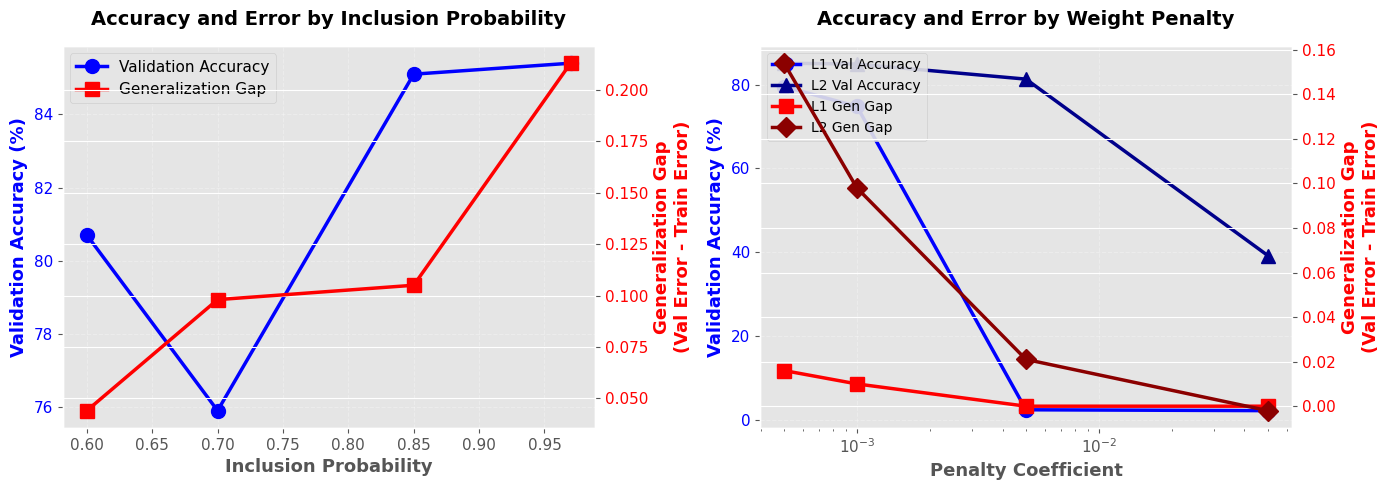

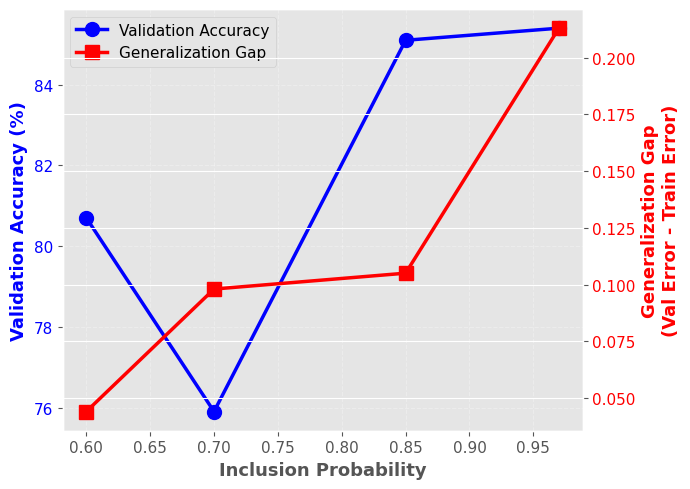

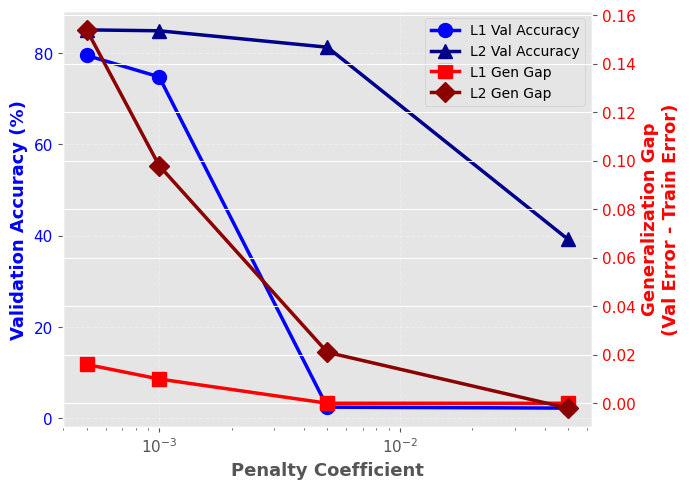

In [48]:
# Data from Table 3 - Dropout experiments
dropout_data = {
    0.6: {'val_acc': 80.7, 'train_err': 0.549, 'val_err': 0.593},
    0.7: {'val_acc': 75.9, 'train_err': 0.664, 'val_err': 0.762},
    0.85: {'val_acc': 85.1, 'train_err': 0.329, 'val_err': 0.434},
    0.97: {'val_acc': 85.4, 'train_err': 0.244, 'val_err': 0.457},
}

# Data from Table 3 - L1 penalty experiments
l1_data = {
    5e-4: {'val_acc': 79.5, 'train_err': 0.642, 'val_err': 0.658},
    1e-3: {'val_acc': 74.8, 'train_err': 0.848, 'val_err': 0.858},
    5e-3: {'val_acc': 2.41, 'train_err': 3.850, 'val_err': 3.850},
    5e-2: {'val_acc': 2.20, 'train_err': 3.850, 'val_err': 3.850},
}

# Data from Table 3 - L2 penalty experiments
l2_data = {
    5e-4: {'val_acc': 85.1, 'train_err': 0.306, 'val_err': 0.460},
    1e-3: {'val_acc': 84.9, 'train_err': 0.361, 'val_err': 0.459},
    5e-3: {'val_acc': 81.3, 'train_err': 0.586, 'val_err': 0.607},
    5e-2: {'val_acc': 39.2, 'train_err': 2.258, 'val_err': 2.256},
}

dropout_probs = []
dropout_val_accs = []
dropout_gen_gaps = []

for prob in sorted(dropout_data.keys()):
    data = dropout_data[prob]
    dropout_probs.append(prob)
    dropout_val_accs.append(data['val_acc'])
    gen_gap = data['val_err'] - data['train_err']
    dropout_gen_gaps.append(gen_gap)
    print(f"Dropout {prob}: Val Acc={data['val_acc']:.1f}%, Gen Gap={gen_gap:.3f}")

print()

l1_coeffs = []
l1_val_accs = []
l1_gen_gaps = []

for coeff in sorted(l1_data.keys()):
    data = l1_data[coeff]
    l1_coeffs.append(coeff)
    l1_val_accs.append(data['val_acc'])
    gen_gap = data['val_err'] - data['train_err']
    l1_gen_gaps.append(gen_gap)
    print(f"L1 {coeff:.0e}: Val Acc={data['val_acc']:.1f}%, Gen Gap={gen_gap:.3f}")

print()

l2_coeffs = []
l2_val_accs = []
l2_gen_gaps = []

for coeff in sorted(l2_data.keys()):
    data = l2_data[coeff]
    l2_coeffs.append(coeff)
    l2_val_accs.append(data['val_acc'])
    gen_gap = data['val_err'] - data['train_err']
    l2_gen_gaps.append(gen_gap)
    print(f"L2 {coeff:.0e}: Val Acc={data['val_acc']:.1f}%, Gen Gap={gen_gap:.3f}")

print("\n" + "="*70)
print("Creating plots...")

# Create the main figure with both subplots
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1_acc = ax1
ax1_gap = ax1.twinx()

# Plot validation accuracy (blue, left axis)
line1 = ax1_acc.plot(dropout_probs, dropout_val_accs, 'o-', color='blue', 
                     linewidth=2.5, markersize=10, label='Validation Accuracy')

# Plot generalization gap (red, right axis)
line2 = ax1_gap.plot(dropout_probs, dropout_gen_gaps, 's-', color='red', 
                     linewidth=2.5, markersize=10, label='Generalization Gap')

# Left axis (accuracy) formatting
ax1_acc.set_xlabel('Inclusion Probability', fontsize=13, fontweight='bold')
ax1_acc.set_ylabel('Validation Accuracy (%)', color='blue', fontsize=13, fontweight='bold')
ax1_acc.tick_params(axis='y', labelcolor='blue', labelsize=11)
ax1_acc.tick_params(axis='x', labelsize=11)
ax1_acc.grid(True, alpha=0.3, linestyle='--')

# Right axis (gap) formatting
ax1_gap.set_ylabel('Generalization Gap\n(Val Error - Train Error)', color='red', 
                   fontsize=13, fontweight='bold')
ax1_gap.tick_params(axis='y', labelcolor='red', labelsize=11)

# Title
ax1.set_title('Accuracy and Error by Inclusion Probability', 
              fontsize=14, fontweight='bold', pad=15)

# Legend
lines1, labels1 = ax1_acc.get_legend_handles_labels()
lines2, labels2 = ax1_gap.get_legend_handles_labels()
ax1_acc.legend(lines1 + lines2, labels1 + labels2, loc='upper left', 
               fontsize=11, framealpha=0.9)


ax2 = fig.add_subplot(1, 2, 2)
ax2_acc = ax2
ax2_gap = ax2.twinx()

# Plot L1 validation accuracy (blue circles, left axis)
line3 = ax2_acc.plot(l1_coeffs, l1_val_accs, 'o-', color='blue', 
                    linewidth=2.5, markersize=10, label='L1 Val Accuracy')

# Plot L2 validation accuracy (dark blue triangles, left axis)
line4 = ax2_acc.plot(l2_coeffs, l2_val_accs, '^-', color='darkblue', 
                    linewidth=2.5, markersize=10, label='L2 Val Accuracy')

# Plot L1 generalization gap (red squares, right axis)
line5 = ax2_gap.plot(l1_coeffs, l1_gen_gaps, 's-', color='red', 
                    linewidth=2.5, markersize=10, label='L1 Gen Gap')

# Plot L2 generalization gap (dark red diamonds, right axis)
line6 = ax2_gap.plot(l2_coeffs, l2_gen_gaps, 'D-', color='darkred', 
                    linewidth=2.5, markersize=10, label='L2 Gen Gap')

# Left axis (accuracy) formatting
ax2_acc.set_xlabel('Penalty Coefficient', fontsize=13, fontweight='bold')
ax2_acc.set_ylabel('Validation Accuracy (%)', color='blue', fontsize=13, fontweight='bold')
ax2_acc.tick_params(axis='y', labelcolor='blue', labelsize=11)
ax2_acc.tick_params(axis='x', labelsize=11)
ax2_acc.set_xscale('log')
ax2_acc.grid(True, alpha=0.3, linestyle='--')

# Right axis (gap) formatting
ax2_gap.set_ylabel('Generalization Gap\n(Val Error - Train Error)', color='red', 
                   fontsize=13, fontweight='bold')
ax2_gap.tick_params(axis='y', labelcolor='red', labelsize=11)

# Title
ax2.set_title('Accuracy and Error by Weight Penalty', 
              fontsize=14, fontweight='bold', pad=15)

# Legend
lines3, labels3 = ax2_acc.get_legend_handles_labels()
lines4, labels4 = ax2_gap.get_legend_handles_labels()
ax2_acc.legend(lines3 + lines4, labels3 + labels4, loc='upper left', 
               fontsize=10, framealpha=0.9)

fig.tight_layout()


# Dropout subplot only
fig_dropout = plt.figure(figsize=(7, 5))
ax = fig_dropout.add_subplot(111)
ax_gap = ax.twinx()

ax.plot(dropout_probs, dropout_val_accs, 'o-', color='blue', 
        linewidth=2.5, markersize=10, label='Validation Accuracy')
ax.set_xlabel('Inclusion Probability', fontsize=13, fontweight='bold')
ax.set_ylabel('Validation Accuracy (%)', color='blue', fontsize=13, fontweight='bold')
ax.tick_params(axis='y', labelcolor='blue', labelsize=11)
ax.tick_params(axis='x', labelsize=11)
ax.grid(True, alpha=0.3, linestyle='--')

ax_gap.plot(dropout_probs, dropout_gen_gaps, 's-', color='red', 
            linewidth=2.5, markersize=10, label='Generalization Gap')
ax_gap.set_ylabel('Generalization Gap\n(Val Error - Train Error)', color='red', 
                  fontsize=13, fontweight='bold')
ax_gap.tick_params(axis='y', labelcolor='red', labelsize=11)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_gap.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='best', fontsize=11, framealpha=0.9)

fig_dropout.tight_layout()
fig_dropout.savefig('empty_dropout_plot.png', dpi=300, bbox_inches='tight')

# Weight penalty subplot only
fig_wd = plt.figure(figsize=(7, 5))
ax = fig_wd.add_subplot(111)
ax_gap = ax.twinx()

ax.plot(l1_coeffs, l1_val_accs, 'o-', color='blue', 
        linewidth=2.5, markersize=10, label='L1 Val Accuracy')
ax.plot(l2_coeffs, l2_val_accs, '^-', color='darkblue', 
        linewidth=2.5, markersize=10, label='L2 Val Accuracy')
ax.set_xlabel('Penalty Coefficient', fontsize=13, fontweight='bold')
ax.set_ylabel('Validation Accuracy (%)', color='blue', fontsize=13, fontweight='bold')
ax.tick_params(axis='y', labelcolor='blue', labelsize=11)
ax.tick_params(axis='x', labelsize=11)
ax.set_xscale('log')
ax.grid(True, alpha=0.3, linestyle='--')

ax_gap.plot(l1_coeffs, l1_gen_gaps, 's-', color='red', 
            linewidth=2.5, markersize=10, label='L1 Gen Gap')
ax_gap.plot(l2_coeffs, l2_gen_gaps, 'D-', color='darkred', 
            linewidth=2.5, markersize=10, label='L2 Gen Gap')
ax_gap.set_ylabel('Generalization Gap\n(Val Error - Train Error)', color='red', 
                  fontsize=13, fontweight='bold')
ax_gap.tick_params(axis='y', labelcolor='red', labelsize=11)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_gap.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='best', fontsize=10, framealpha=0.9)

fig_wd.tight_layout()

plt.show()

Saved: figures/l1l2_validation_accuracy.pdf


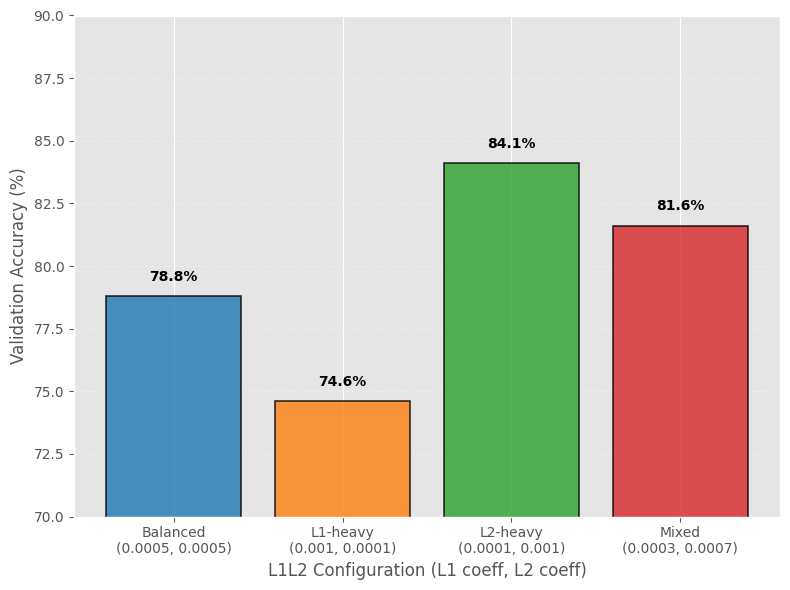

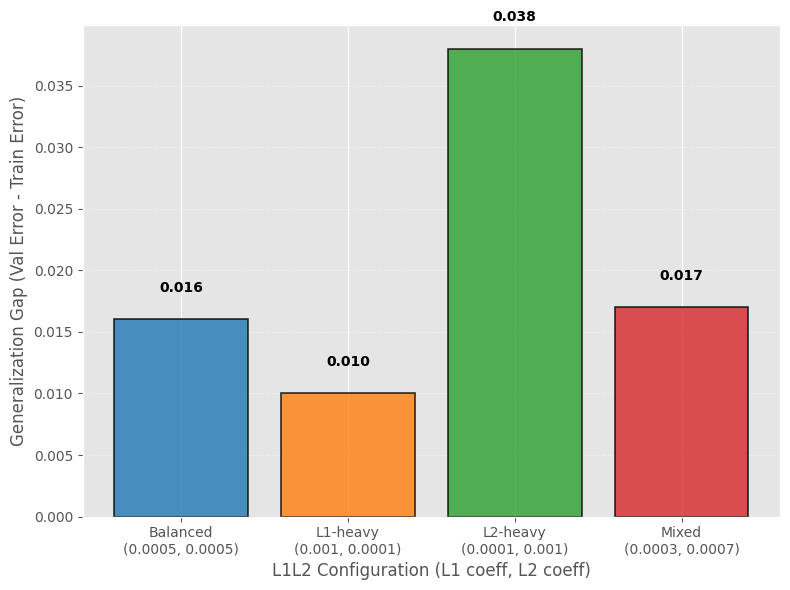

Figure 5 complete
Configurations tested:
  Balanced    :  78.8% accuracy,  0.016 gap
  L1-heavy    :  74.6% accuracy,  0.010 gap
  L2-heavy    :  84.1% accuracy,  0.038 gap
  Mixed       :  81.6% accuracy,  0.017 gap


In [49]:
configs = ['Balanced\n(0.0005, 0.0005)', 
           'L1-heavy\n(0.001, 0.0001)', 
           'L2-heavy\n(0.0001, 0.001)', 
           'Mixed\n(0.0003, 0.0007)']

val_accs = [78.8, 74.6, 84.1, 81.6]
train_errors = [0.690, 0.858, 0.460, 0.570]
val_errors = [0.706, 0.868, 0.498, 0.587]

# Calculate generalization gaps
gen_gaps = [val_errors[i] - train_errors[i] for i in range(4)]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Figure 1: Validation Accuracy
fig1 = plt.figure(figsize=(8, 6))
ax1 = fig1.add_subplot(1, 1, 1)
bars1 = ax1.bar(range(4), val_accs, color=colors, alpha=0.8, 
                edgecolor='black', linewidth=1.2)
ax1.set_xlabel('L1L2 Configuration (L1 coeff, L2 coeff)', fontsize=12)
ax1.set_ylabel('Validation Accuracy (%)', fontsize=12)
ax1.set_xticks(range(4))
ax1.set_xticklabels(configs, fontsize=10)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim([70, 90])

for bar, val in zip(bars1, val_accs):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
             f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

fig1.tight_layout()
print("Saved: figures/l1l2_validation_accuracy.pdf")

# Figure 2: Generalization Gap
fig2 = plt.figure(figsize=(8, 6))
ax2 = fig2.add_subplot(1, 1, 1)
bars2 = ax2.bar(range(4), gen_gaps, color=colors, alpha=0.8, 
                edgecolor='black', linewidth=1.2)
ax2.set_xlabel('L1L2 Configuration (L1 coeff, L2 coeff)', fontsize=12)
ax2.set_ylabel('Generalization Gap (Val Error - Train Error)', fontsize=12)
ax2.set_xticks(range(4))
ax2.set_xticklabels(configs, fontsize=10)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

for bar, val in zip(bars2, gen_gaps):
    y_pos = bar.get_height() + 0.002 if bar.get_height() > 0 else bar.get_height() - 0.002
    va = 'bottom' if bar.get_height() > 0 else 'top'
    ax2.text(bar.get_x() + bar.get_width()/2., y_pos, f'{val:.3f}',
             ha='center', va=va, fontsize=10, fontweight='bold')

fig2.tight_layout()

plt.show()

print("Figure 5 complete")
print("Configurations tested:")
for i, name in enumerate(['Balanced', 'L1-heavy', 'L2-heavy', 'Mixed']):
    print(f"  {name:12s}: {val_accs[i]:5.1f}% accuracy, {gen_gaps[i]:6.3f} gap")


KeysView(NpzFile '/Users/ashu/Downloads/MLP/mlp_cw2/mlpractical/data/emnist-train.npz' with keys: inputs, targets)
KeysView(NpzFile '/Users/ashu/Downloads/MLP/mlp_cw2/mlpractical/data/emnist-valid.npz' with keys: inputs, targets)
KeysView(NpzFile '/Users/ashu/Downloads/MLP/mlp_cw2/mlpractical/data/emnist-test.npz' with keys: inputs, targets)
Training BEST MODEL: Dropout p=0.97


Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 248.59it/s]
Epoch 1: 4.0s to complete
    error(train)=1.44e+00, acc(train)=6.05e-01, error(valid)=1.44e+00, acc(valid)=5.99e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 217.63it/s]
Epoch 2: 4.7s to complete
    error(train)=1.16e+00, acc(train)=6.72e-01, error(valid)=1.17e+00, acc(valid)=6.68e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 280.79it/s]
Epoch 3: 3.6s to complete
    error(train)=1.02e+00, acc(train)=7.07e-01, error(valid)=1.03e+00, acc(valid)=7.04e-01
Ep Prog: 100%|██████████| 1000/1000 [00:04<00:00, 244.92it/s]
Epoch 4: 4.1s to complete
    error(train)=9.15e-01, acc(train)=7.32e-01, error(valid)=9.30e-01, acc(valid)=7.28e-01
Ep Prog: 100%|██████████| 1000/1000 [00:02<00:00, 341.73it/s]
Epoch 5: 2.9s to complete
    error(train)=8.39e-01, acc(train)=7.51e-01, error(valid)=8.55e-01, acc(valid)=7.45e-01
Ep Prog: 100%|██████████| 1000/1000 [00:03<00:00, 268.70it/s]
Epoch 6: 3.7s to complete
    error(train)=

Final Validation Accuracy: 0.853
Final Validation Error: 0.447
Final Training Error: 0.240
Generalization Gap: 0.208
EVALUATING ON TEST SET

Test Set Results:
  Test Accuracy: 0.8433 (84.33%)
  Test Error: 0.4830
  Training Error: 0.2398
  Test Generalization Gap: 0.2432

 SUMMARY - Best Model (Dropout p=0.97):
   Validation Accuracy: 85.34%
   Test Accuracy: 84.33%
   Validation Gen Gap: 0.2077
   Test Gen Gap: 0.2432


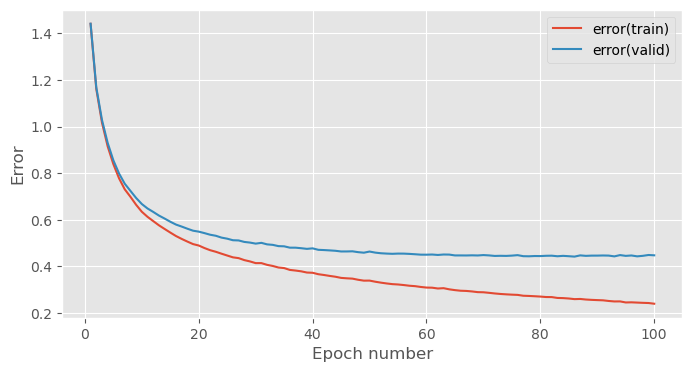

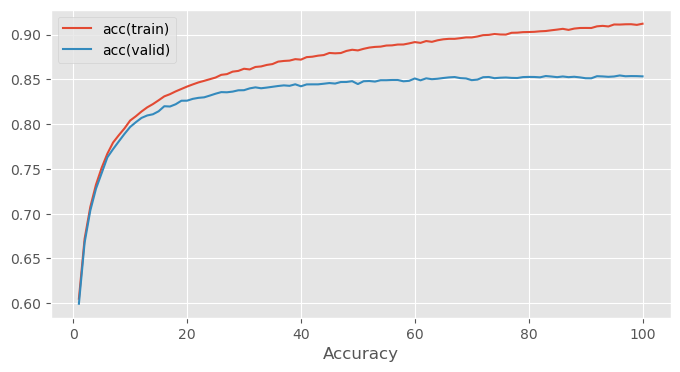

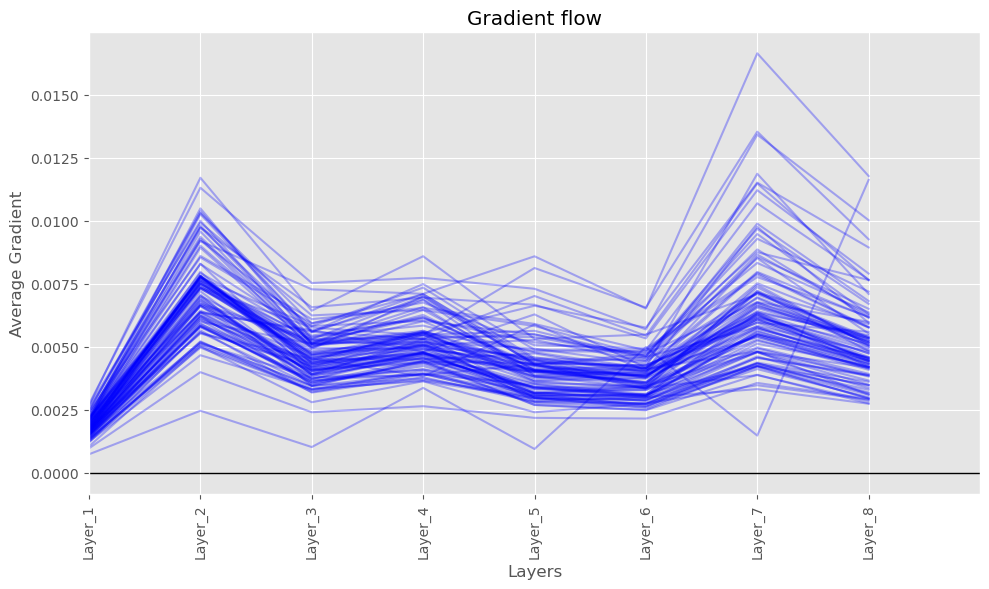

In [11]:
# Test set evaluation for the best model
import numpy as np
from mlp.data_providers import EMNISTDataProvider
from mlp.layers import AffineLayer, ReluLayer, DropoutLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule
from mlp.optimisers import Optimiser


seed = 111020
rng = np.random.RandomState(seed)
batch_size = 100

# using 'test' split
train_data = EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
valid_data = EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
input_dim = 784
output_dim = 47

print("Training BEST MODEL: Dropout p=0.97")

# Reset data providers
train_data.reset()
valid_data.reset()

# Build model with Dropout p=0.97 (your best configuration)
layer1 = AffineLayer(input_dim, 128, weights_init, biases_init)
activation1 = ReluLayer()
dropout1 = DropoutLayer(rng=rng, incl_prob=0.97)

layer2 = AffineLayer(128, 128, weights_init, biases_init)
activation2 = ReluLayer()
dropout2 = DropoutLayer(rng=rng, incl_prob=0.97)

layer3 = AffineLayer(128, 128, weights_init, biases_init)
activation3 = ReluLayer()
dropout3 = DropoutLayer(rng=rng, incl_prob=0.97)

layer_out = AffineLayer(128, output_dim, weights_init, biases_init)

layers = [layer1, activation1, dropout1, 
          layer2, activation2, dropout2, 
          layer3, activation3, dropout3, 
          layer_out]
model = MultipleLayerModel(layers)

error = CrossEntropySoftmaxError()
learning_rule = AdamLearningRule(learning_rate=0.0001)

# Train the model
stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, grad_plot, grad_ax = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, 100, 1, notebook=False)

print(f"Final Validation Accuracy: {stats[-1, keys['acc(valid)']]:.3f}")
print(f"Final Validation Error: {stats[-1, keys['error(valid)']]:.3f}")
print(f"Final Training Error: {stats[-1, keys['error(train)']]:.3f}")
print(f"Generalization Gap: {stats[-1, keys['error(valid)']] - stats[-1, keys['error(train)']]:.3f}")

print("EVALUATING ON TEST SET")

test_data.reset()
test_error = 0.
test_acc = 0.
num_batches = 0

for inputs_batch, targets_batch in test_data:
    # Forward pass with evaluation=True (no dropout during testing)
    activations = model.fprop(inputs_batch, evaluation=True)
    
    # Calculate error
    test_error += error(activations[-1], targets_batch)
    
    # Calculate accuracy
    predictions = activations[-1].argmax(axis=1)
    targets = targets_batch.argmax(axis=1)
    test_acc += (predictions == targets).mean()
    
    num_batches += 1

# Average over all batches
test_error /= num_batches
test_acc /= num_batches

print(f"\nTest Set Results:")
print(f"  Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  Test Error: {test_error:.4f}")
print(f"  Training Error: {stats[-1, keys['error(train)']]:.4f}")
print(f"  Test Generalization Gap: {test_error - stats[-1, keys['error(train)']]:.4f}")

# Save the test results
best_model_results = {
    'validation_accuracy': stats[-1, keys['acc(valid)']],
    'validation_error': stats[-1, keys['error(valid)']],
    'training_error': stats[-1, keys['error(train)']],
    'test_accuracy': test_acc,
    'test_error': test_error,
    'test_gen_gap': test_error - stats[-1, keys['error(train)']],
    'validation_gen_gap': stats[-1, keys['error(valid)']] - stats[-1, keys['error(train)']]
}

print("\n SUMMARY - Best Model (Dropout p=0.97):")
print(f"   Validation Accuracy: {best_model_results['validation_accuracy']*100:.2f}%")
print(f"   Test Accuracy: {best_model_results['test_accuracy']*100:.2f}%")
print(f"   Validation Gen Gap: {best_model_results['validation_gen_gap']:.4f}")
print(f"   Test Gen Gap: {best_model_results['test_gen_gap']:.4f}")